# ECE 498 DS Mini Project 2

### Jingde Chen(jingdec2), Yunhan Wang (ywang530), Takumi Li(feiyang3)

# Task 1: Data Cleaning and Visual Inspection

## 0. Getting Started With the Data

In [1]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from IPython.display import HTML

In [2]:
RA_HE0 = pd.read_csv('Data/RelativeAbundance_HE0.csv', index_col='Microbe Name')
RA_HE1 = pd.read_csv('Data/RelativeAbundance_HE1.csv', index_col='Microbe Name')
RA_df = pd.concat([RA_HE0, RA_HE1], axis=1)

In [3]:
assert(RA_HE0.shape[1] + RA_HE1.shape[1] == RA_df.shape[1])
assert(RA_HE0.shape[0] == RA_HE1.shape[0])

### 1. In the context of statistical analysis, why do biologists need multiple samples to identify microbes with significantly altered abundance?

Larger number of samples helps reduce the error caused by the fluctuation in the data. The larger the sample size, the more convincing conclusion we can draw from the data.

### 2. How many samples were analyzed?

In [4]:
print(f'A total of {RA_HE0.shape[1]} samples were analyzed.')

A total of 764 samples were analyzed.


### 3. How many microbes were identified?

In [5]:
print("There were {} identified microbes.".format(RA_HE0.shape[0]))

There were 149 identified microbes.


## 1. Bayesian Network for Quality Control

### a. Give the factorization of the joint probability distribution.

Let the variables be denoted as \
S = Storage Temp \
M = Collection Method \
C = Contamination     \
T = Lab Time Before Processing \
Q = Quality \
$P(Q, C, T, S, M)=P(Q|C,T,S,M)P(C|T,S,M)P(T|S,M)P(S|M)P(M)$ \
\
$P(S|M) = P(S)$ \
$P(T|S,M) = P(T)$ \
$P(C|T,S,M) = P(C|S,M)$ \
$P(Q|C,T,S,M) = P(Q|C,T)$ \
\
$P(Q, C, T, S, M)= P(Q|C,T)P(C|S,M)P(T)P(S)P(M)$

### b. Count the number of parameters needed to define the conditional probability distribution of the Bayesian Network for quality control.

A total of $4+4+1+1+1=11$ parameters are needed. \
$(2-1)*(2*2)=4$ parameters for $P(Q|C,T)$ \
$(2-1)*(2*2)=4$ parameters for $P(C|S,M)$ \
$(2-1)=1$ parameter for $P(T)$ \
$(2-1)=1$ parameter for $P(S)$ \
$(2-1)=1$ parameter for $P(M)$

### c. Show the conditional probability tables P(Quality|Contamination, Lab Time), P(Contamination|Storage Temp, Collection Method), P(Storage Temp), P(Collection Method), P(Lab Time) for the above network.

In [6]:
qc_df = pd.read_csv('Data/QualityControl.csv')
qc_df.keys()

Index(['strtmp', 'coll', 'labtime', 'cont', 'qual'], dtype='object')

In [7]:
variables = {
    'qual': ['good', 'bad'],
    'cont': ['low', 'high'],
    'labtime': ['short', 'long'],
    'strtmp': ['cold', 'cool'],
    'coll': ['nurse', 'patient']
    }

In [8]:
def cond_3(v, d1, d2, d3):
    cond_table = {}
    for val_d1 in variables[d1]:
        for val_d2 in variables[d2]:
            for val_d3 in variables[d3]:
                cond_table[(val_d1, val_d2, val_d3)] = {}
                for val_v in variables[v]:
                    count = (qc_df[d1].eq(val_d1) & qc_df[d2].eq(val_d2) & qc_df[d3].eq(val_d3) & qc_df[v].eq(val_v)).sum()
                    total = (qc_df[d1].eq(val_d1) & qc_df[d2].eq(val_d2) & qc_df[d3].eq(val_d3)).sum()
                    cond_table[(val_d1, val_d2, val_d3)][val_v] = count / total
    return cond_table

In [9]:
def cond_2(v, d1, d2):
    cond_table = {}
    for val_d1 in variables[d1]:
        for val_d2 in variables[d2]:
            cond_table[(val_d1, val_d2)] = {}
            for val_v in variables[v]:
                count = (qc_df[d1].eq(val_d1) & qc_df[d2].eq(val_d2) & qc_df[v].eq(val_v)).sum()
                total = (qc_df[d1].eq(val_d1) & qc_df[d2].eq(val_d2)).sum()
                cond_table[(val_d1, val_d2)][val_v] = count / total
    return cond_table

In [10]:
def cond_1(v, d):
    cond_table = {}
    for val_d in variables[d]:
        cond_table[val_d] = {}
        for val_v in variables[v]:
            count = (qc_df[d].eq(val_d) & qc_df[v].eq(val_v)).sum()
            total = qc_df[d].eq(val_d).sum()
            cond_table[val_d][val_v] = count / total
    return cond_table

In [11]:
def prob(v):
    prob_table = {}
    for val_v in variables[v]:
        prob_table[val_v] = qc_df[v].eq(val_v).sum() / len(qc_df[v])
    return prob_table

In [12]:
p_Q_CT = cond_2('qual', 'cont', 'labtime')
p_C_SM = cond_2('cont', 'strtmp', 'coll')
p_S = prob('strtmp')
p_M = prob('coll')
p_T = prob('labtime')

In [13]:
print(p_Q_CT, '\n', p_C_SM, '\n', p_S, '\n', p_M, '\n', p_T)

{('low', 'short'): {'good': 0.9570930544381872, 'bad': 0.04290694556181282}, ('low', 'long'): {'good': 0.9190031152647975, 'bad': 0.08099688473520249}, ('high', 'short'): {'good': 0.9357429718875502, 'bad': 0.0642570281124498}, ('high', 'long'): {'good': 0.03389830508474576, 'bad': 0.9661016949152542}} 
 {('cold', 'nurse'): {'low': 0.9560168025698048, 'high': 0.04398319743019521}, ('cold', 'patient'): {'low': 0.9234234234234234, 'high': 0.07657657657657657}, ('cool', 'nurse'): {'low': 0.9115646258503401, 'high': 0.08843537414965986}, ('cool', 'patient'): {'low': 0.16176470588235295, 'high': 0.8382352941176471}} 
 {'cold': 0.8982, 'cool': 0.1018} 
 {'nurse': 0.8976, 'patient': 0.1024} 
 {'short': 0.7956, 'long': 0.2044}


In [14]:
def dump_pt2(v, d1, d2, table):
    pt_df = pd.DataFrame(columns=[d1, d2]+[f'{v} = {val_v}' for val_v in variables[v]]).set_index([d1, d2])
    for deps, cond_probs in table.items():
        pt_df.loc[(deps[0], deps[1]), :] = [cond_probs[val_v] for val_v in variables[v]]
    return pt_df

pt = dump_pt2('qual', 'cont', 'labtime', p_Q_CT)
pt

qual = good qual = bad
cont labtime                       
low  short      0.957093  0.0429069
     long       0.919003  0.0809969
high short      0.935743   0.064257
     long      0.0338983   0.966102

In [15]:
def dump_pt2(v, d1, d2, table):
    pt_df = pd.DataFrame(columns=[d1, d2]+[f'{v} = {val_v}' for val_v in variables[v]])
    for deps, cond_probs in table.items():
        pt_df.loc[len(pt_df)] = [deps[0], deps[1]] + [cond_probs[val_v] for val_v in variables[v]]
    return pt_df

pt = dump_pt2('qual', 'cont', 'labtime', p_Q_CT)

In [16]:
def dump_pt2(v, d1, d2, table):
    rows = []
    for deps, cond_probs in table.items():
        rows.append([f'{deps[0]}, {deps[1]}'] + [cond_probs[val_v] for val_v in variables[v]])
    return pd.DataFrame(rows, columns=[f'{d1}, {d2}']+[f'{v} = {val_v}' for val_v in variables[v]]).set_index(f'{d1}, {d2}')

pt = dump_pt2('qual', 'cont', 'labtime', p_Q_CT)

In [17]:
def dump_pt3(v, d1, d2, d3, table):
    rows = []
    for deps, cond_probs in table.items():
        rows.append([f'{deps[0]}, {deps[1]}, {deps[2]}'] + [cond_probs[val_v] for val_v in variables[v]])
    return pd.DataFrame(rows, columns=[f'{d1}, {d2}, {d3}']+[f'{v} = {val_v}' for val_v in variables[v]]).set_index(f'{d1}, {d2}, {d3}')

### d. Calculate P(Quality|Storage Temp, Collection Method, Lab Time) for all possible values of Quality, Storage Temp, Collection method, and Lab Time.

$P(Q|S,M,T) \space \space \text{All possible values:}$ \
 \
$P(Q=good|S=cold,M=nurse,T=short)$ \
$P(Q=good|S=cold,M=nurse,T=long)$ \
$P(Q=good|S=cold,M=patient,T=short)$ \
$P(Q=good|S=cold,M=patient,T=long)$ \
$P(Q=good|S=cool,M=nurse,T=short)$ \
$P(Q=good|S=cool,M=nurse,T=long)$ \
$P(Q=good|S=cool,M=patient,T=short)$ \
$P(Q=good|S=cool,M=patient,T=long)$ \
 \
$P(Q=bad|S=cold,M=nurse,T=short)$ \
$P(Q=bad|S=cold,M=nurse,T=long)$ \
$P(Q=bad|S=cold,M=patient,T=short)$ \
$P(Q=bad|S=cold,M=patient,T=long)$ \
$P(Q=bad|S=cool,M=nurse,T=short)$ \
$P(Q=bad|S=cool,M=nurse,T=long)$ \
$P(Q=bad|S=cool,M=patient,T=short)$ \
$P(Q=bad|S=cool,M=patient,T=long)$

In [18]:
qual_condi_p = {}
for q in ['good','bad']:
    for s in ['cold', 'cool']:
        for m in ['nurse', 'patient']:
            for t in ['short', 'long']:
                M = qc_df[(qc_df['labtime'] == t) & (qc_df['coll'] == m) & (qc_df['strtmp'] == s)].shape[0]
                N = qc_df[(qc_df['labtime'] == t) & (qc_df['coll'] == m) & (qc_df['strtmp'] == s) & (qc_df['qual'] == q)].shape[0]
                probability = N/M
#                 probability = (N/qc_df.shape[0])/(p_S[s] * p_M[m] * p_T[t])
                if((s,m,t)) not in qual_condi_p:
                    qual_condi_p[(s,m,t)] = [(probability, q)]
                else:
                    qual_condi_p[(s,m,t)].append((probability, q))
                  
                print("P(Q={}|S={},M={},T={}) = {}".format(q,s,m,t,probability))
    print('\n')

P(Q=good|S=cold,M=nurse,T=short) = 0.9551122194513716
P(Q=good|S=cold,M=nurse,T=long) = 0.8879618593563766
P(Q=good|S=cold,M=patient,T=short) = 0.9439775910364145
P(Q=good|S=cold,M=patient,T=long) = 0.8620689655172413
P(Q=good|S=cool,M=nurse,T=short) = 0.9723756906077348
P(Q=good|S=cool,M=nurse,T=long) = 0.8227848101265823
P(Q=good|S=cool,M=patient,T=short) = 0.9607843137254902
P(Q=good|S=cool,M=patient,T=long) = 0.11764705882352941


P(Q=bad|S=cold,M=nurse,T=short) = 0.04488778054862843
P(Q=bad|S=cold,M=nurse,T=long) = 0.11203814064362336
P(Q=bad|S=cold,M=patient,T=short) = 0.056022408963585436
P(Q=bad|S=cold,M=patient,T=long) = 0.13793103448275862
P(Q=bad|S=cool,M=nurse,T=short) = 0.027624309392265192
P(Q=bad|S=cool,M=nurse,T=long) = 0.17721518987341772
P(Q=bad|S=cool,M=patient,T=short) = 0.0392156862745098
P(Q=bad|S=cool,M=patient,T=long) = 0.8823529411764706




In [19]:
p_Q_SMT = cond_3('qual', 'strtmp', 'coll', 'labtime')
dump_pt3('qual', 'strtmp', 'coll', 'labtime', p_Q_SMT)

qual = good  qual = bad
strtmp, coll, labtime                         
cold, nurse, short        0.955112    0.044888
cold, nurse, long         0.887962    0.112038
cold, patient, short      0.943978    0.056022
cold, patient, long       0.862069    0.137931
cool, nurse, short        0.972376    0.027624
cool, nurse, long         0.822785    0.177215
cool, patient, short      0.960784    0.039216
cool, patient, long       0.117647    0.882353

In [20]:
qc_df[(qc_df['labtime'] == 'long') & (qc_df['coll'] == 'patient') & (qc_df['strtmp'] == 'cool') & (qc_df['qual'] == 'bad')].shape[0]

15

### e. Use the calculated conditional probabilities and the collected data BayesInferenceHE0.csv, BayesInferenceHE1.csv to determine the quality of the analyzed stool samples given data on the Storage Temperature, Collection Method, and Lab Time Before Processing. Report bad quality samples. Drop bad quality data for the following analyses.

In [21]:
bayes_HE0_df = pd.read_csv('Data/BayesInferenceHE0.csv')
bayes_HE1_df = pd.read_csv('Data/BayesInferenceHE1.csv')
quality = []
for index, row in bayes_HE0_df.iterrows():
      quality.append(max(qual_condi_p[(row['strtmp'], row['coll'], row['labtime'])])[1])
bayes_HE0_df['qual'] = quality

quality = []
for index, row in bayes_HE1_df.iterrows():
      quality.append(max(qual_condi_p[(row['strtmp'], row['coll'], row['labtime'])])[1])
bayes_HE1_df['qual'] = quality

In [22]:
print(bayes_HE0_df[bayes_HE0_df['qual'] =='bad'].index)
print(bayes_HE1_df[bayes_HE1_df['qual'] =='bad'].index)

Int64Index([699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711,
            712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724,
            725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737,
            738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750,
            751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763],
           dtype='int64')
Int64Index([699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711,
            712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724,
            725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737,
            738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750,
            751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763],
           dtype='int64')


In [23]:
# Identify bad sample names
bad_sample_HE0 = list(bayes_HE0_df[bayes_HE0_df['qual']=='bad']['SampleName'])
bad_sample_HE1 = list(bayes_HE1_df[bayes_HE1_df['qual']=='bad']['SampleName'])
print(f'Number of samples dropped from HE0: {len(bad_sample_HE0)}, HE1: {len(bad_sample_HE0)} Total: {len(bad_sample_HE0) + len(bad_sample_HE1)}')

# Drop bad sample and copy to new dataframes
RA_HE0_df = RA_HE0.drop(columns=bad_sample_HE0, inplace=False)
RA_HE1_df = RA_HE1.drop(columns=bad_sample_HE1, inplace=False)

Number of samples dropped from HE0: 65, HE1: 65 Total: 130


## 2. Data Standardization

### 1. Verify Relative Abundance

In [24]:
check = []
for index, value in RA_HE0_df.sum(axis=0).items():
    if value >= 1.0 + 10**(-10) or value <= 1.0 - 10**(-10):
        check.append(index)
        
if len(check) == 0:
    print('Yes, HE0 meets the requirements of the sum of all the values for each sample should be 1.')
else:
    RA_HE0_df.drop(check)
    
    
check = []
for index, value in RA_HE1_df.sum(axis=0).items():
    if value >= 1.0 + 10**(-10) or value <= 1.0 - 10**(-10):
        check.append(index)
        
if len(check) == 0:
    print('Yes, HE1 meets the requirements of the sum of all the values for each sample should be 1.')
else:
    RA_HE1_df.drop(check)

Yes, HE0 meets the requirements of the sum of all the values for each sample should be 1.
Yes, HE1 meets the requirements of the sum of all the values for each sample should be 1.


### 2. Discussion on Relative Abundance Data

The benefit of using relative abundance is that all data entries we get are on the same scale. But we lose the absolute abundance of the microbes, which is the magnitude of each data.

## 3. Visual Inspection

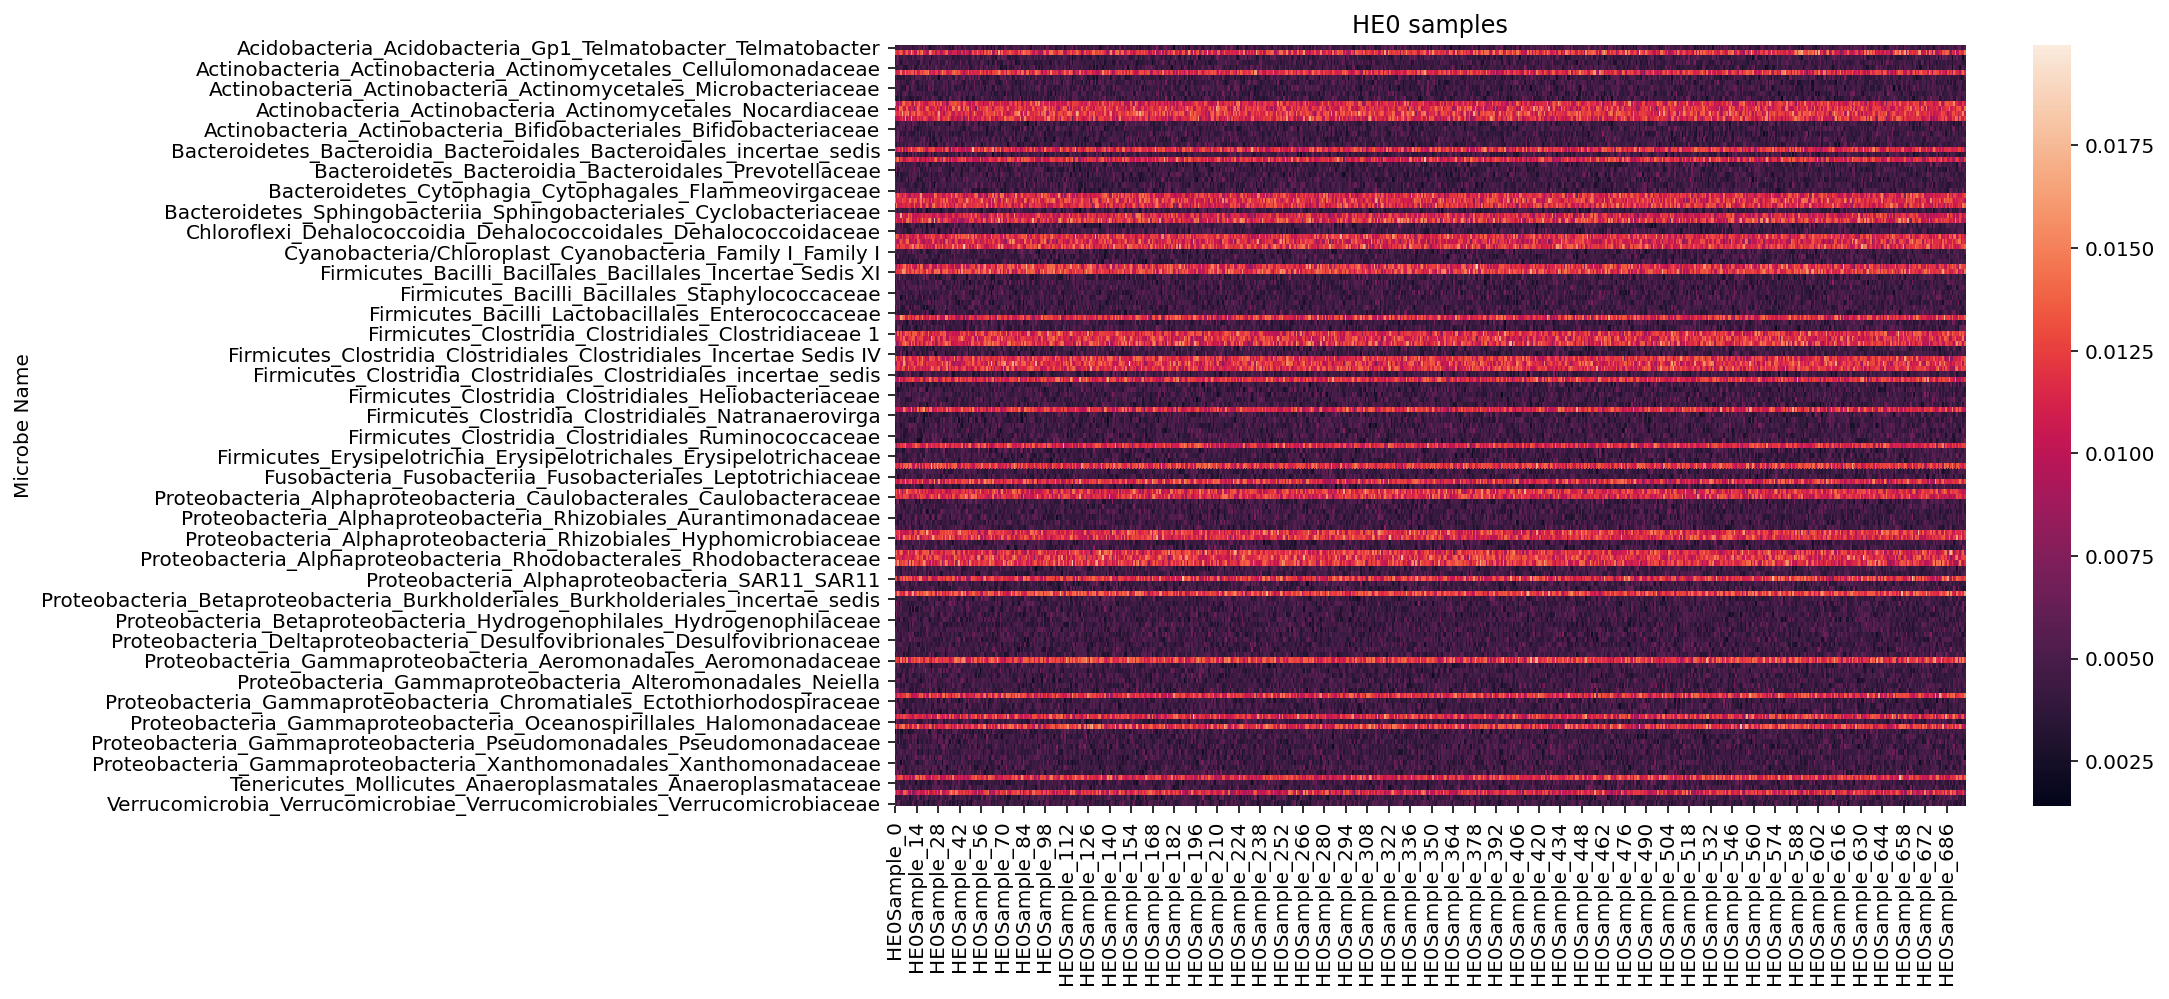

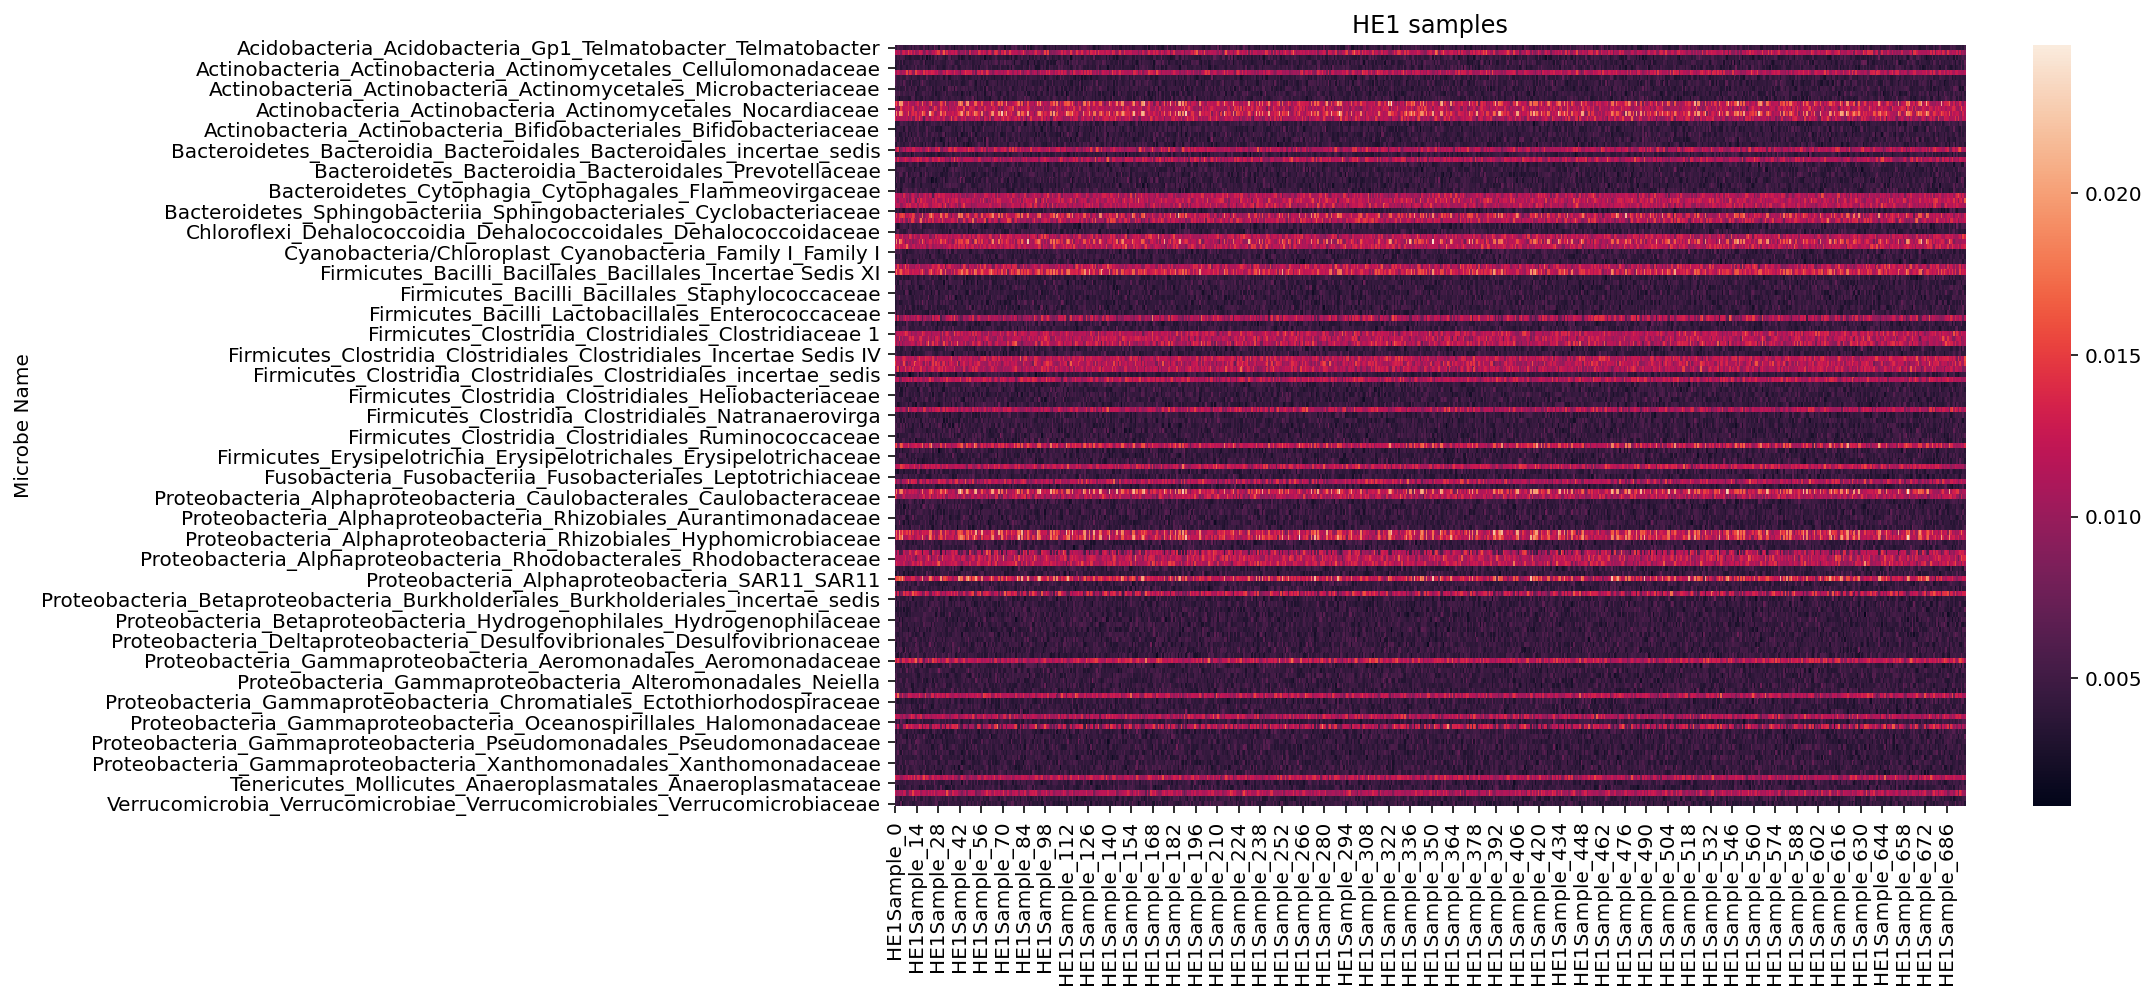

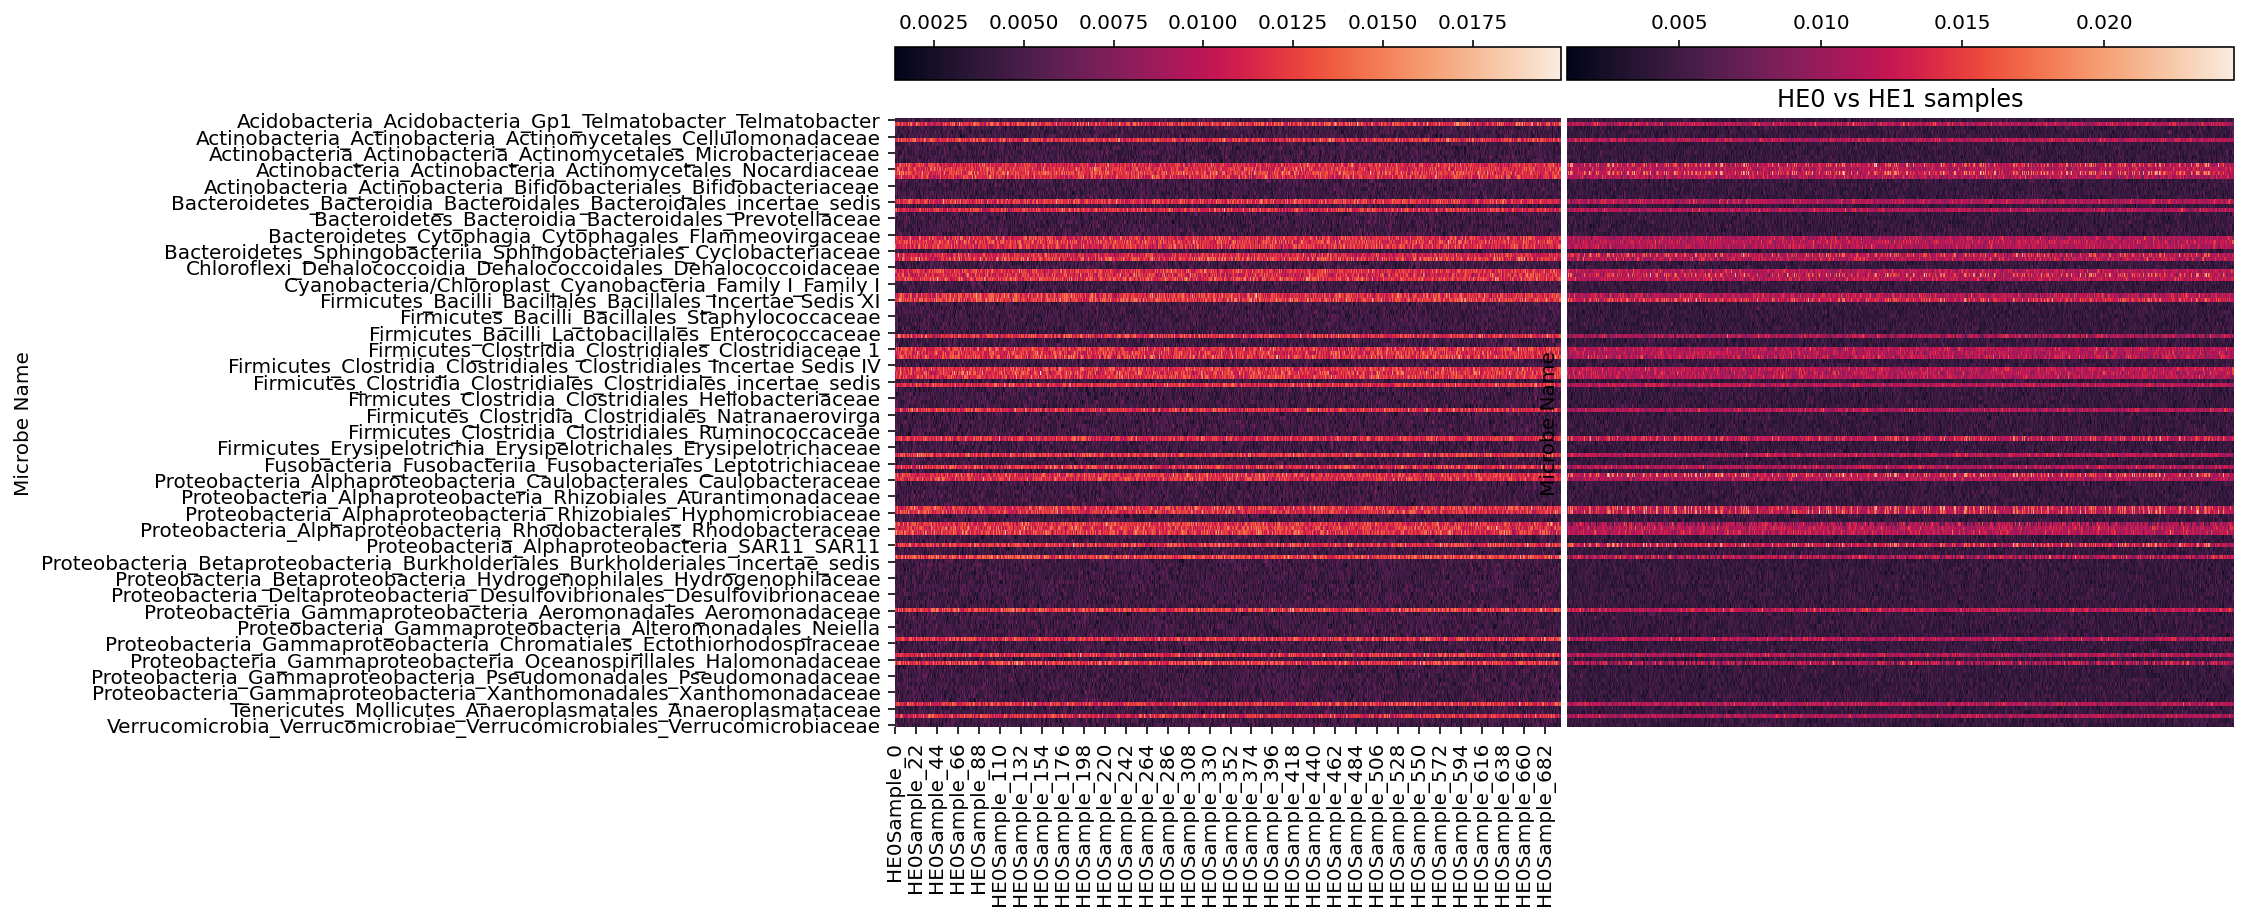

In [25]:
plt.figure()
sns.heatmap(RA_HE0_df)
plt.title('HE0 samples')
plt.savefig('HE0 samples.png', bbox_inches='tight')

plt.figure()
sns.heatmap(RA_HE1_df)
plt.title('HE1 samples')
plt.savefig('HE1 samples.png', bbox_inches='tight')

fig, (ax,ax2) = plt.subplots(ncols=2)
fig.subplots_adjust(wspace=0.01)
sns.heatmap(RA_HE0_df, ax=ax, cbar=False)
fig.colorbar(ax.collections[0], ax=ax,location="top", use_gridspec=False)
sns.heatmap(RA_HE1_df, ax=ax2, cbar=False, xticklabels = False, yticklabels = False)
fig.colorbar(ax2.collections[0], ax=ax2,location="top", use_gridspec=False)
ax2.yaxis.tick_right()
ax2.tick_params(rotation=0)
plt.title('HE0 vs HE1 samples')
plt.savefig('HE0 vs HE1 samples.png', bbox_inches='tight')

# Task 2: Statistical Analysis

## 1. Kolmogorov-Smirnov (KS) Test

### a. p-value for Two-Sample KS Test

In [26]:
microbe_ks2smp = {}
print("P-value of 2-sample KS test on each microbe across HE0 and HE1 samples:")
for microbe, HE0 in RA_HE0_df.iterrows():
    HE1 = RA_HE1_df.loc[microbe]
    ks, p_value = stats.ks_2samp(HE0, HE1)
    microbe_ks2smp[microbe] = p_value
    print(f'{microbe: <80} {p_value}')

P-value of 2-sample KS test on each microbe across HE0 and HE1 samples:
Acidobacteria_Acidobacteria_Gp1_Telmatobacter_Telmatobacter                      0.18048636329971207
Acidobacteria_Acidobacteria_Gp3_Gp3_Gp3                                          0.0026644997271667516
Actinobacteria_Actinobacteria_Acidimicrobiales_Acidimicrobiaceae                 0.11036728525525359
Actinobacteria_Actinobacteria_Actinomycetales_Actinomycetaceae                   0.5406327654432803
Actinobacteria_Actinobacteria_Actinomycetales_Cellulomonadaceae                  0.9374281357582129
Actinobacteria_Actinobacteria_Actinomycetales_Corynebacteriaceae                 0.00026178088641558295
Actinobacteria_Actinobacteria_Actinomycetales_Dermabacteraceae                   0.34506649186619204
Actinobacteria_Actinobacteria_Actinomycetales_Geodermatophilaceae                0.14196321989830799
Actinobacteria_Actinobacteria_Actinomycetales_Microbacteriaceae                  0.7630055398361942
Actinobacteria_Ac

Proteobacteria_Gammaproteobacteria_Aeromonadales_Aeromonadaceae                  0.055916019292977515
Proteobacteria_Gammaproteobacteria_Aeromonadales_Succinivibrionaceae             0.8048470687671236
Proteobacteria_Gammaproteobacteria_Alteromonadales_Celerinatantimonadaceae       0.34506649186619204
Proteobacteria_Gammaproteobacteria_Alteromonadales_Ferrimonadaceae               0.4567499059147121
Proteobacteria_Gammaproteobacteria_Alteromonadales_Neiella                       0.055916019292977515
Proteobacteria_Gammaproteobacteria_Alteromonadales_Pseudoalteromonadaceae        0.6294372757512614
Proteobacteria_Gammaproteobacteria_Candidatus Carsonella_Candidatus Carsonella   0.9109514162026923
Proteobacteria_Gammaproteobacteria_Chromatiales_Chromatiaceae                    0.00026178088641558295
Proteobacteria_Gammaproteobacteria_Chromatiales_Ectothiorhodospiraceae           0.28148878333009875
Proteobacteria_Gammaproteobacteria_Enterobacteriales_Enterobacteriaceae          0.8048470

### b. What is the null hypothesis of the KS test in our context? Use one microbe as an example to explain your answer.

Using microbe Acidobacteria_Acidobacteria_Gp3_Gp3_Gp3 as an example.

H_0: The relative abundance levels of microbe Acidobacteria_Acidobacteria_Gp3_Gp3_Gp3 from the HE0 sample patients and HE1 sample patients follow the same distribution, which means the microbe’s abundance is not altered.

### c. Number of Genes with Significantly Altered Expression at Various Alpha Values

In [27]:
alpha_levels = [0.1, 0.05, 0.01, 0.005, 0.001]
alpha_counts = {al: 0 for al in alpha_levels}
for microbe, p_value in microbe_ks2smp.items():
    for al in alpha_levels:
        if p_value < al:
            alpha_counts[al] += 1
table = pd.DataFrame(alpha_counts.items(), columns=['Alpha Level', '# of Altered Microbes'])
HTML(table.to_html(index=False))

## 2. Multiple Testing

### a. P-value

P-value is the probability of obtaining test results at least as extreme as the results actually observed during the test, assuming that the null hypothesis is correct.

In our context, a p-value of 0.05 represents a 5% probability of observing the threshold KS test statistic or a more extreme KS test statistic, given that the microbe’s abundance is not altered in the HE0 and HE1 samples.

### b. P-value Distribution

If the null hypothesis is true, the P-value will follow a uniform distribution on the interval [0, 1].

### c. Expected Number of Significant p-values

In [28]:
table['Significant p-values expected'] = [al * len(RA_HE0_df) for al in alpha_levels]
HTML(table.to_html(index=False))

### d. Q-Q plot of p-values

#### i. Sample N p-values from the expected distribution in Task 2.2.(referred to as expected p-values "microbe_ks2smp").


In [29]:
#Sample N p-values from a uniform distribution (N = len(microbe_ks2smp) = 149)
expected_pvalues = np.random.uniform(0,1,len(microbe_ks2smp)).tolist()
observed_pvalues = list(microbe_ks2smp.values())

#### ii. Take the -log10() of observed p-values and expected p-values.

In [30]:
expected_log = -np.log10(expected_pvalues)
observed_log = -np.log10(observed_pvalues)
print('-log10() of expected p-values', expected_log)
print('\n-log10() of observed p-values', observed_log)

-log10() of expected p-values [4.87562356e-01 1.06871189e+00 1.98134013e-03 5.45946330e-01
 1.10546804e-01 8.89847074e-01 4.09706976e-02 1.19217517e-01
 6.59735962e-02 4.25971424e-01 1.52932112e-01 2.72777514e-01
 3.10665678e-01 6.68819167e-01 1.80185287e-01 5.77365466e-01
 3.15520348e-01 9.76253481e-01 6.00194929e-02 2.64890045e-01
 8.32493737e-02 4.67538228e-01 9.14514053e-01 1.25218630e-01
 3.79072366e-01 3.41703971e-01 5.20531462e-02 1.19053473e+00
 8.38257766e-01 1.13675292e+00 1.51876239e-01 7.00694557e-01
 5.83490942e-02 7.39835139e-01 1.77541134e-01 1.71313885e-01
 4.59871627e-01 4.88853725e-01 6.26035044e-03 1.20512452e+00
 2.23661890e-01 5.65930889e-01 1.64623307e-01 2.71157766e-01
 2.75301873e-01 5.17843874e-01 6.39862729e-01 7.08779690e-01
 4.24174399e-01 3.66199212e-02 9.24748720e-03 4.62082679e-01
 4.52861780e-01 6.73613344e-02 3.45269298e-01 1.30408649e+00
 1.16264986e-01 2.54823848e-01 2.58402819e-02 4.22052940e-01
 1.13817674e-01 5.52996695e-01 5.66653496e-02 1.0832985

#### iii. Rank observed p-values and expected p-values in ascending order separately

In [31]:
expected_log = np.sort(expected_log)
observed_log = np.sort(observed_log)
print('ascending order of expected p-values', expected_log)
print('\nascending order of observed p-values', observed_log)

ascending order of expected p-values [1.50619600e-03 1.98134013e-03 6.26035044e-03 9.24748720e-03
 1.53558438e-02 1.95868187e-02 2.14934680e-02 2.52056639e-02
 2.58402819e-02 3.66199212e-02 3.91891020e-02 4.09706976e-02
 5.15086594e-02 5.20531462e-02 5.66653496e-02 5.67388852e-02
 5.83490942e-02 6.00194929e-02 6.40979547e-02 6.59735962e-02
 6.73613344e-02 6.92709776e-02 7.26422333e-02 7.41487773e-02
 7.45115399e-02 7.46901739e-02 8.24552245e-02 8.32493737e-02
 8.95341014e-02 9.18897284e-02 1.03566360e-01 1.10546804e-01
 1.13817674e-01 1.16264986e-01 1.17062755e-01 1.19217517e-01
 1.21781351e-01 1.25218630e-01 1.40322823e-01 1.41303575e-01
 1.51876239e-01 1.52932112e-01 1.61588577e-01 1.64079819e-01
 1.64623307e-01 1.65934250e-01 1.71313885e-01 1.73156394e-01
 1.77541134e-01 1.80185287e-01 1.81663041e-01 1.81911143e-01
 1.84533074e-01 1.88200744e-01 2.01694357e-01 2.02826396e-01
 2.08531717e-01 2.11939868e-01 2.16320276e-01 2.23661890e-01
 2.49338796e-01 2.50513867e-01 2.54823848e-01 2.

#### Combine the following step and plot.
#### iv. Take the pair of smallest p-values (one from observed p-values, one from expected p-values) and plot a point on an x-y plot with the observed p-value on the Y-axis and the expected p-value on the X-axis. 
#### v. Repeat (iv) for the next smallest pair, for the next smallest, and so on until you have plotted all N pairs in order.
#### vi. Add the x=y line to your plot.

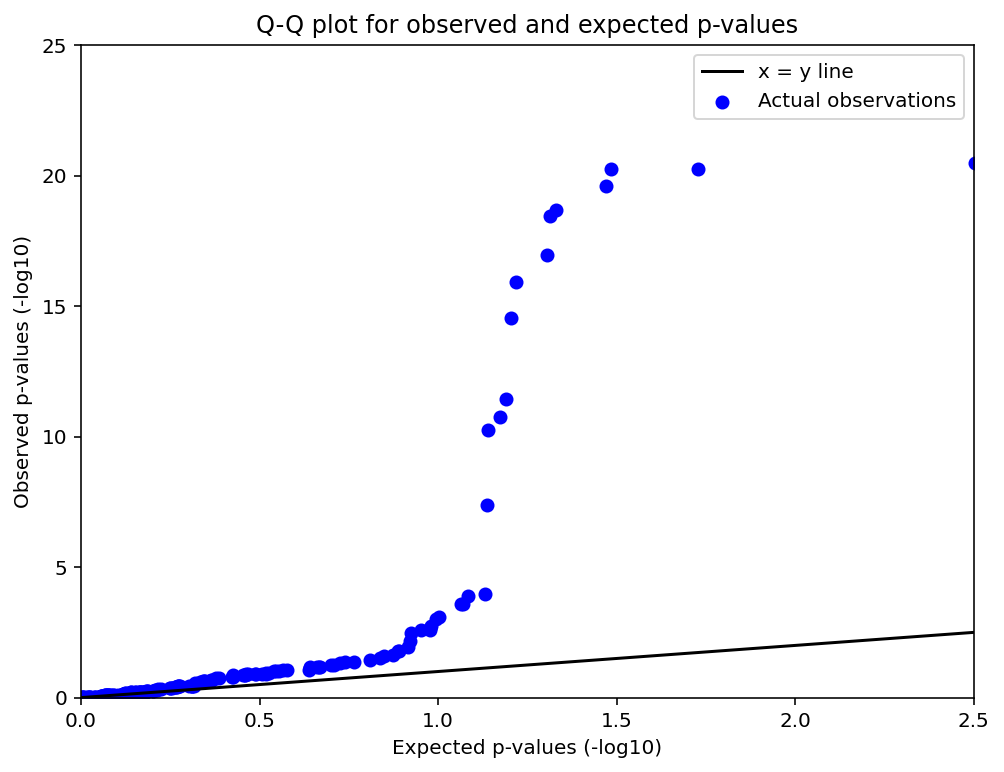

In [32]:
plt.figure(figsize = (8,6))
plt.scatter(expected_log, observed_log,label= 'Actual observations', c='Blue')
plt.title('Q-Q plot for observed and expected p-values')
plt.xlabel('Expected p-values (-log10)')
plt.ylabel('Observed p-values (-log10)') 
plt.xlim([0,2.5])
plt.ylim([0,25])
plt.plot([0,25],[0,25], label = 'x = y line', color = 'black')
plt.legend()

plt.show()

### e. Follow-up Questions

#### i. How does taking the -log10() of the p-values help you visualize the p-value distribution?

After taking log10(p-values) the ones with the highest values of log10(p-values) are the ones in the tail of the p-value distribution and are more visible.

#### ii. What can you conclude from the Q-Q plot?

The Q-Q plot does NOT align with the x=y, which means that the p-values are not uniformly distributed implying that the null hypothesis is likely not true.

# Task 3: Dimensionality Reduction and Clustering

## 1. PCA

### a. Performing PCA

In [33]:
from sklearn.decomposition import PCA
pca_model_0 = PCA(svd_solver='full')
pca_model_1 = PCA(svd_solver='full')
RA_HE0_pc = pca_model_0.fit_transform(RA_HE0_df.T)
RA_HE1_pc = pca_model_1.fit_transform(RA_HE1_df.T)

#### b. Order the principal components by decreasing contribution to total variance. Plot a scree plot to show the fraction of total variance in the data as explained by each principal component. How many principal components are needed in order to explain 30% of the total variance?

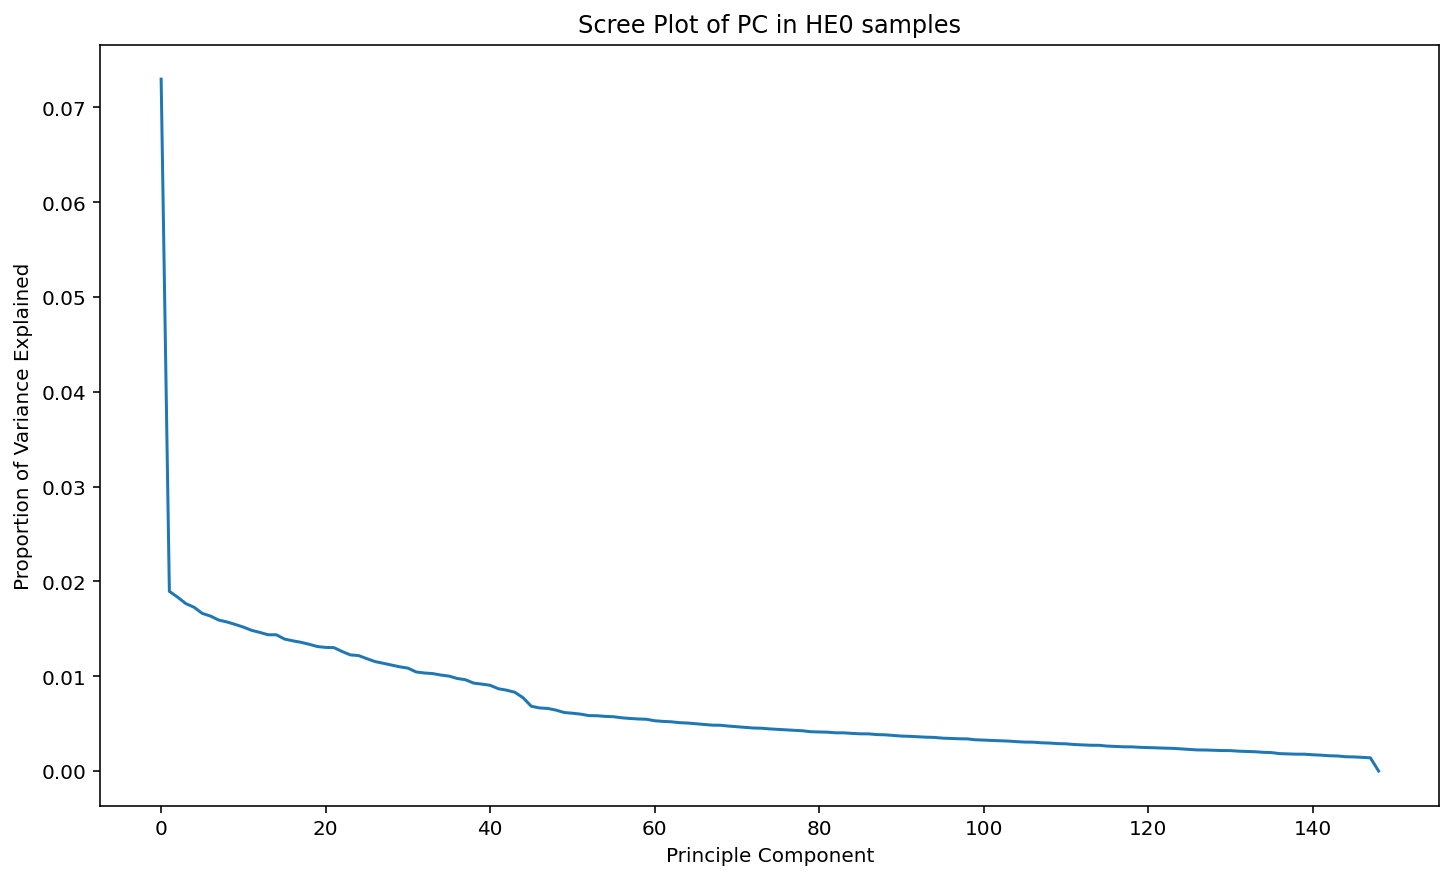

16 principle components are needed to explain 30% of the total variance in HE0 samples.


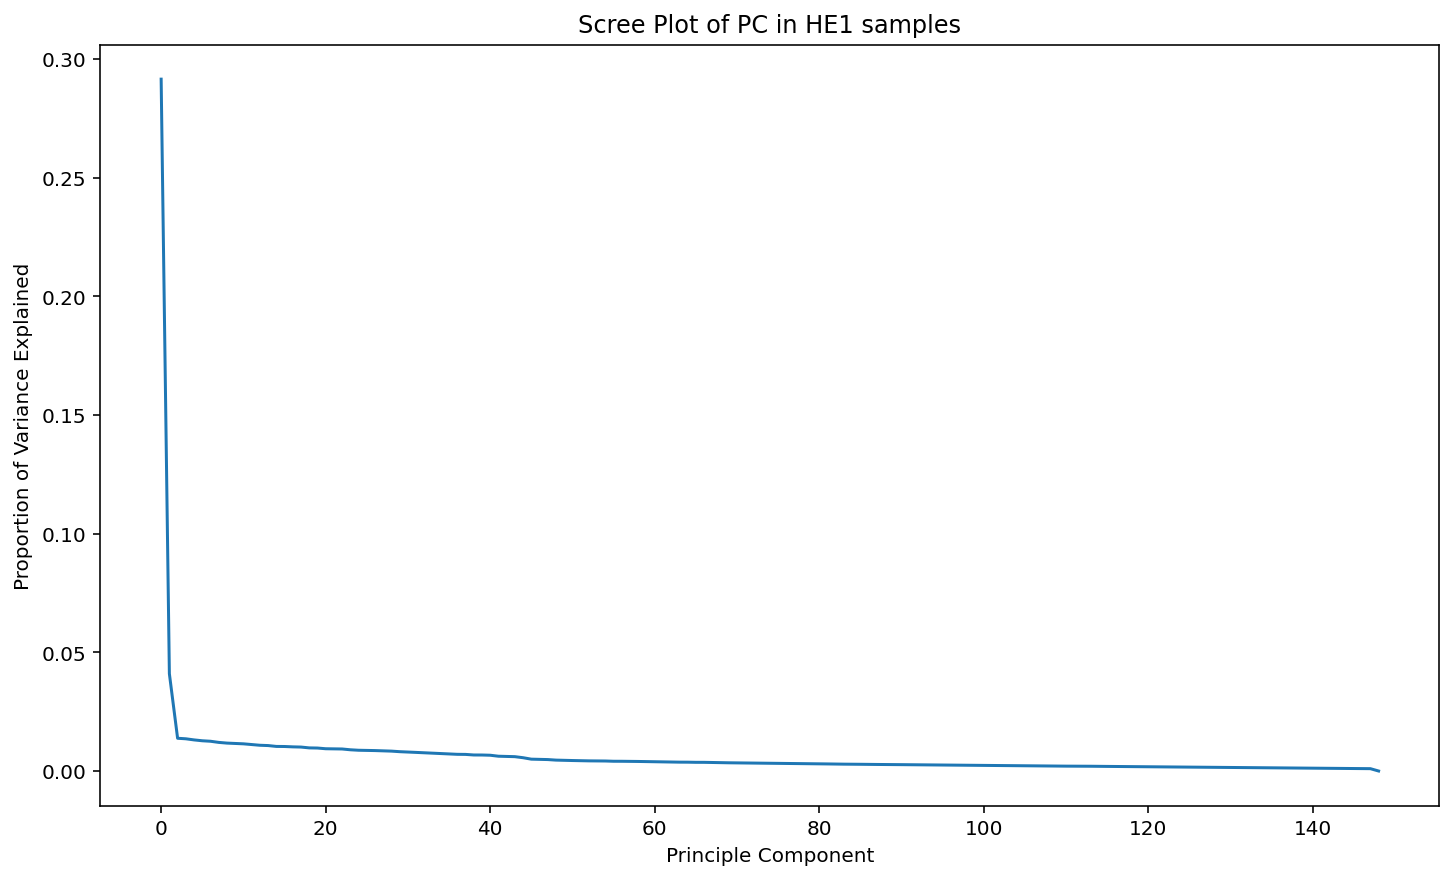

2 principle components are needed to explain 30% of the total variance in HE1 samples.


In [34]:
# HE0
plt.figure()
plt.plot(pca_model_0.explained_variance_ratio_)
plt.title('Scree Plot of PC in HE0 samples')
plt.xlabel('Principle Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

sum_ev = 0
for i in range(pca_model_0.n_components_):
    sum_ev += pca_model_0.explained_variance_ratio_[i]
    if sum_ev >= 0.3:
        print(f'{i+1} principle components are needed to explain 30% of the total variance in HE0 samples.')
        break

# HE1
plt.figure()
plt.plot(pca_model_1.explained_variance_ratio_)
plt.title('Scree Plot of PC in HE1 samples')
plt.xlabel('Principle Component')
plt.ylabel('Proportion of Variance Explained')

plt.show()

sum_ev = 0
for i in range(pca_model_1.n_components_):
    sum_ev += pca_model_1.explained_variance_ratio_[i]
    if sum_ev >= 0.3:
        print(f'{i+1} principle components are needed to explain 30% of the total variance in HE1 samples.')
        break

### c. Scatter Plot of Microbe Abundance

In [35]:
pca_model_0 = PCA(n_components=2, svd_solver='full')
pca_model_1 = PCA(n_components=2, svd_solver='full')
RA_HE0_2pc = pca_model_0.fit_transform(RA_HE0_df.T)
RA_HE0_2pc_df = pd.DataFrame(data=RA_HE0_2pc, columns=['PC1','PC2'])
RA_HE1_2pc = pca_model_1.fit_transform(RA_HE1_df.T)
RA_HE1_2pc_df = pd.DataFrame(data=RA_HE1_2pc, columns=['PC1','PC2'])

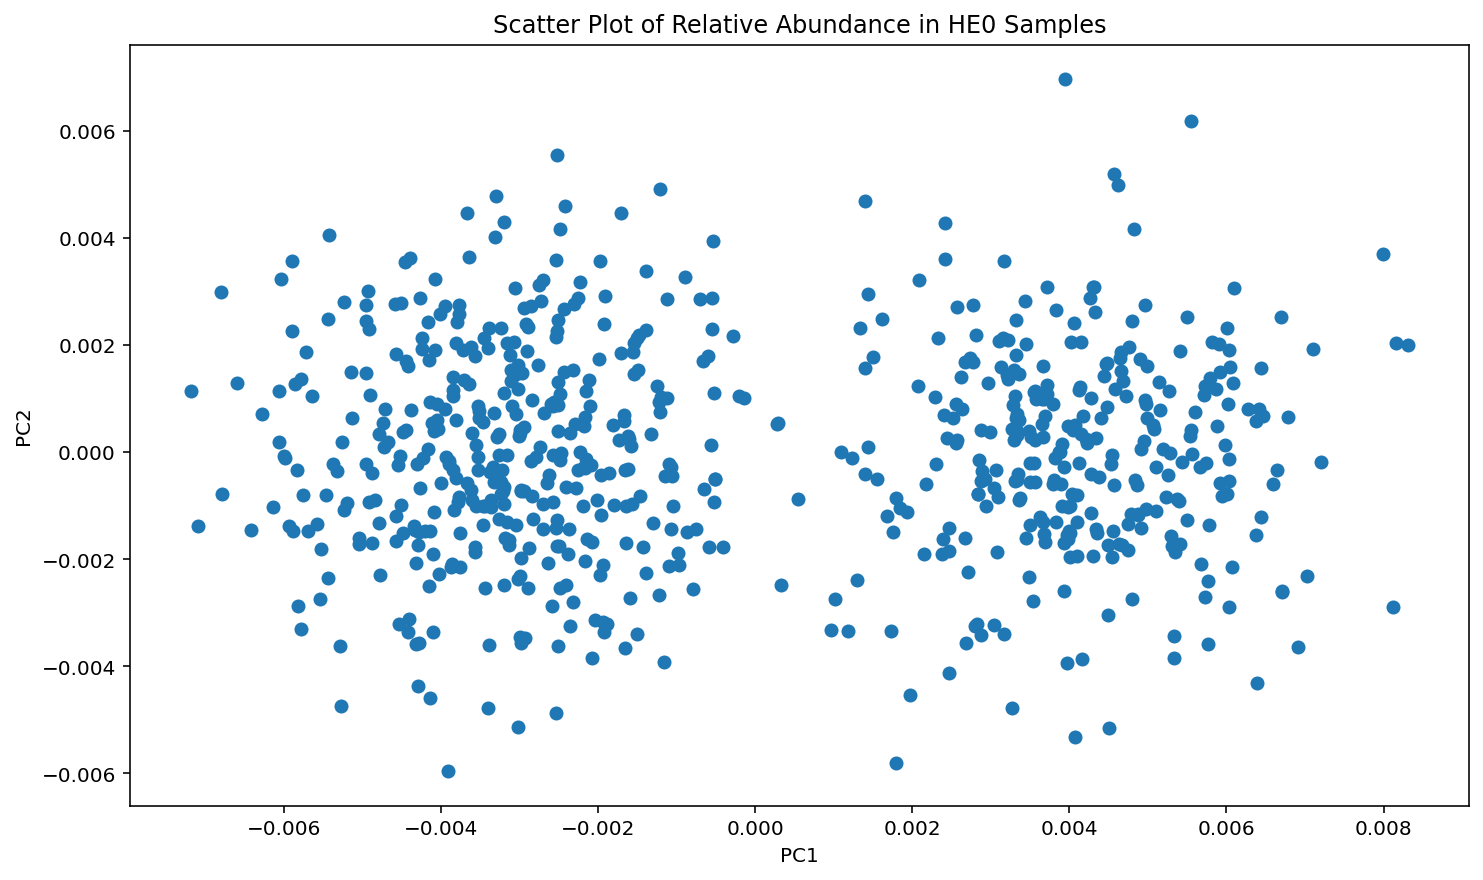

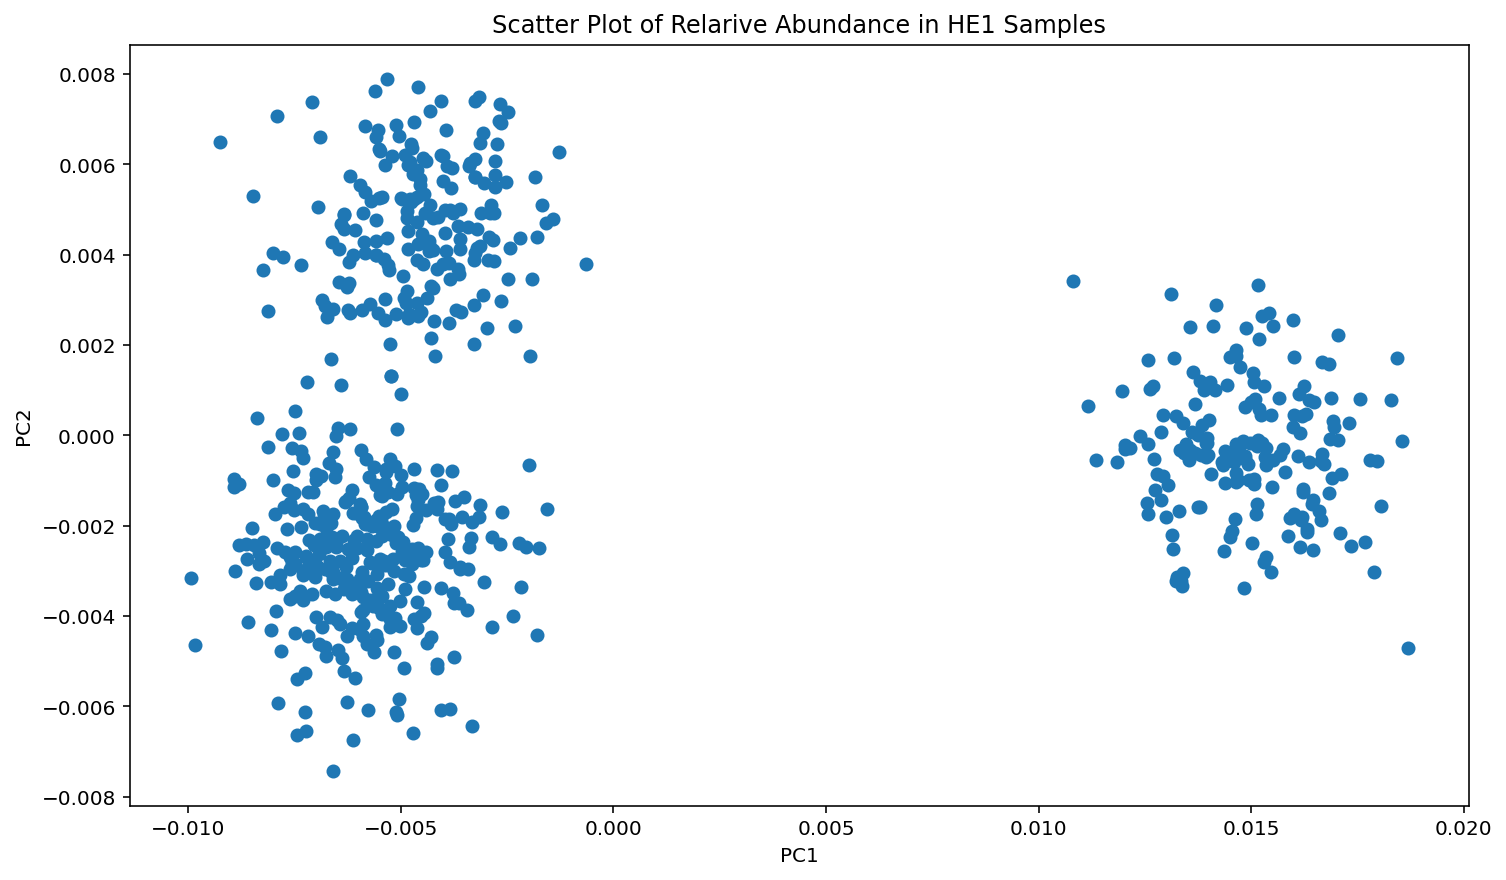

In [36]:
plt.scatter(RA_HE0_2pc_df.PC1, RA_HE0_2pc_df.PC2)
plt.title('Scatter Plot of Relative Abundance in HE0 Samples')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

plt.scatter(RA_HE1_2pc_df.PC1, RA_HE1_2pc_df.PC2)
plt.title('Scatter Plot of Relarive Abundance in HE1 Samples')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

## 2. t-SNE

### a. Performing t-SNE

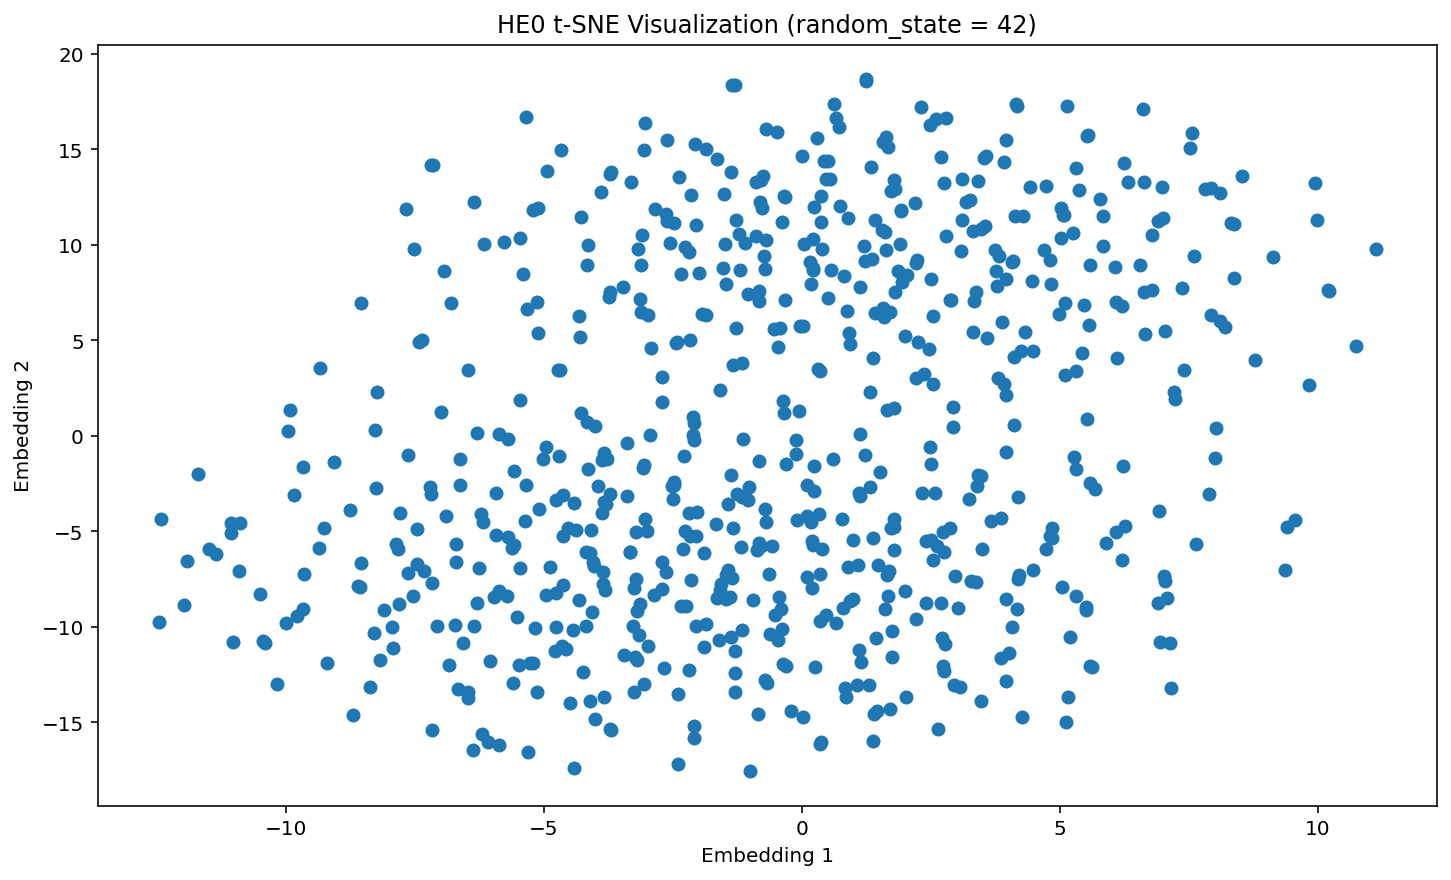

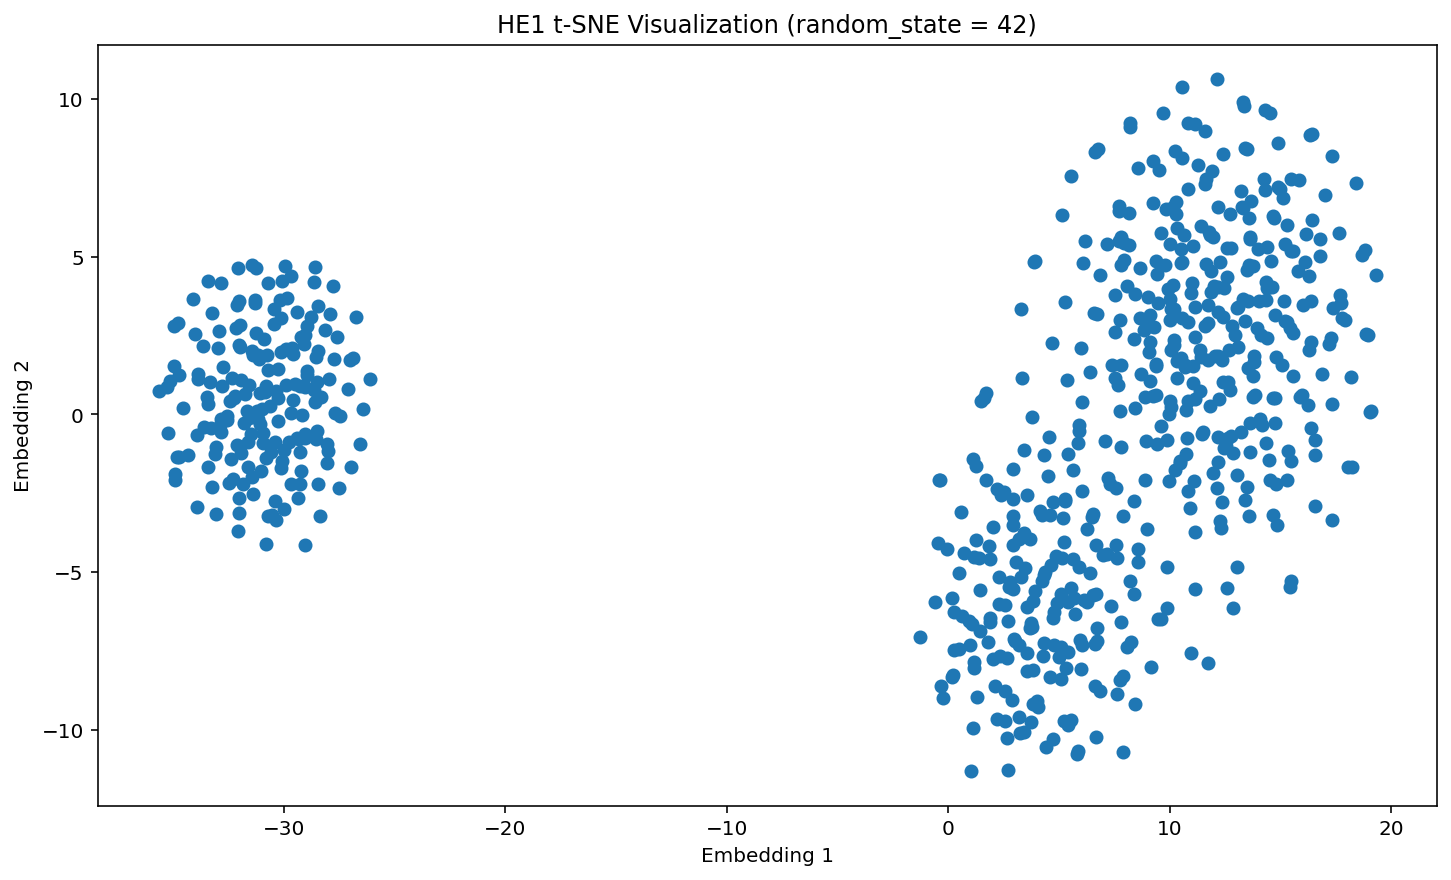

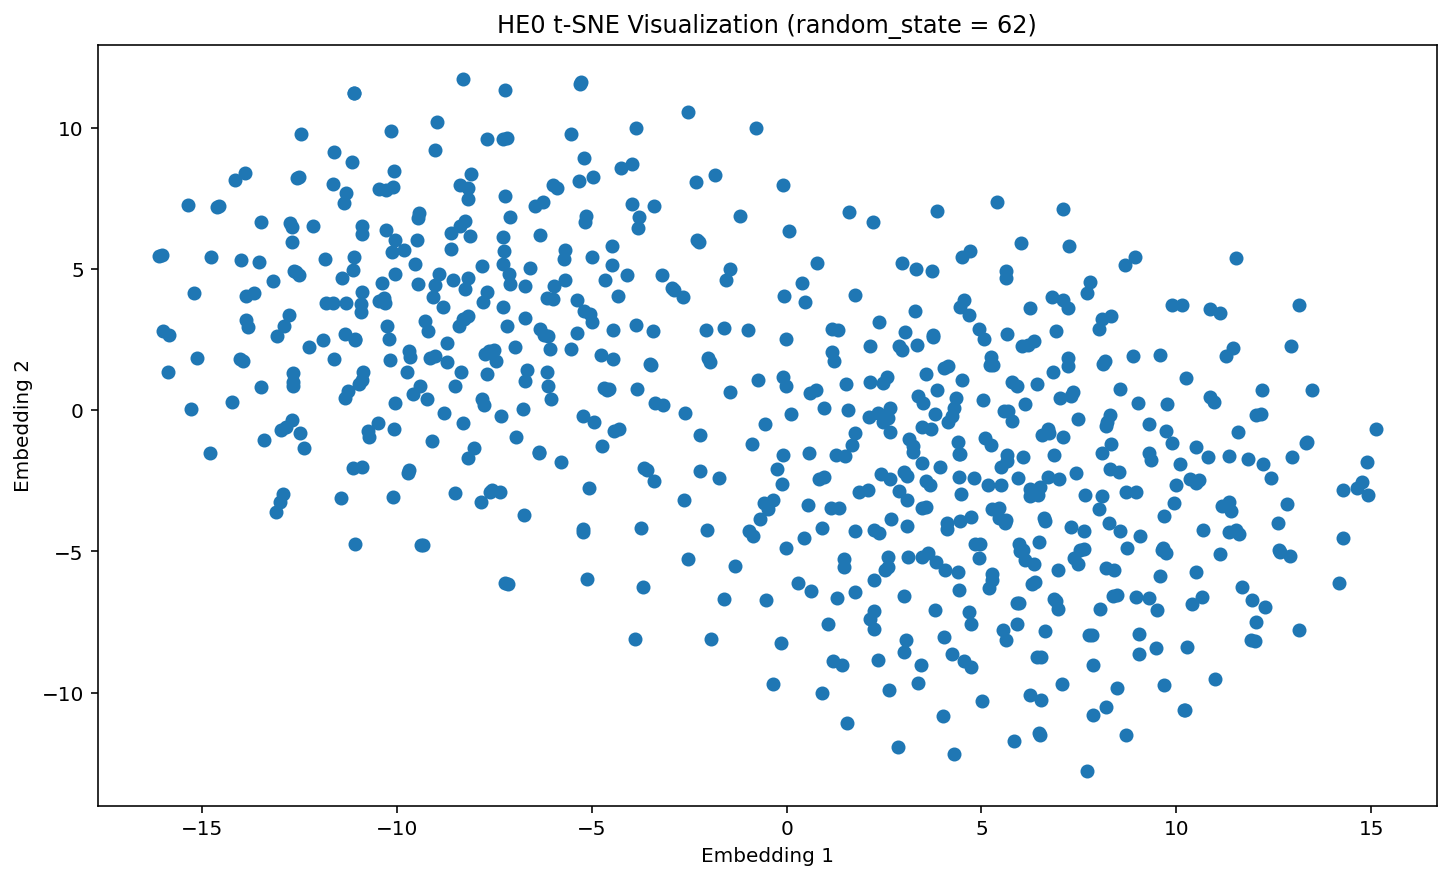

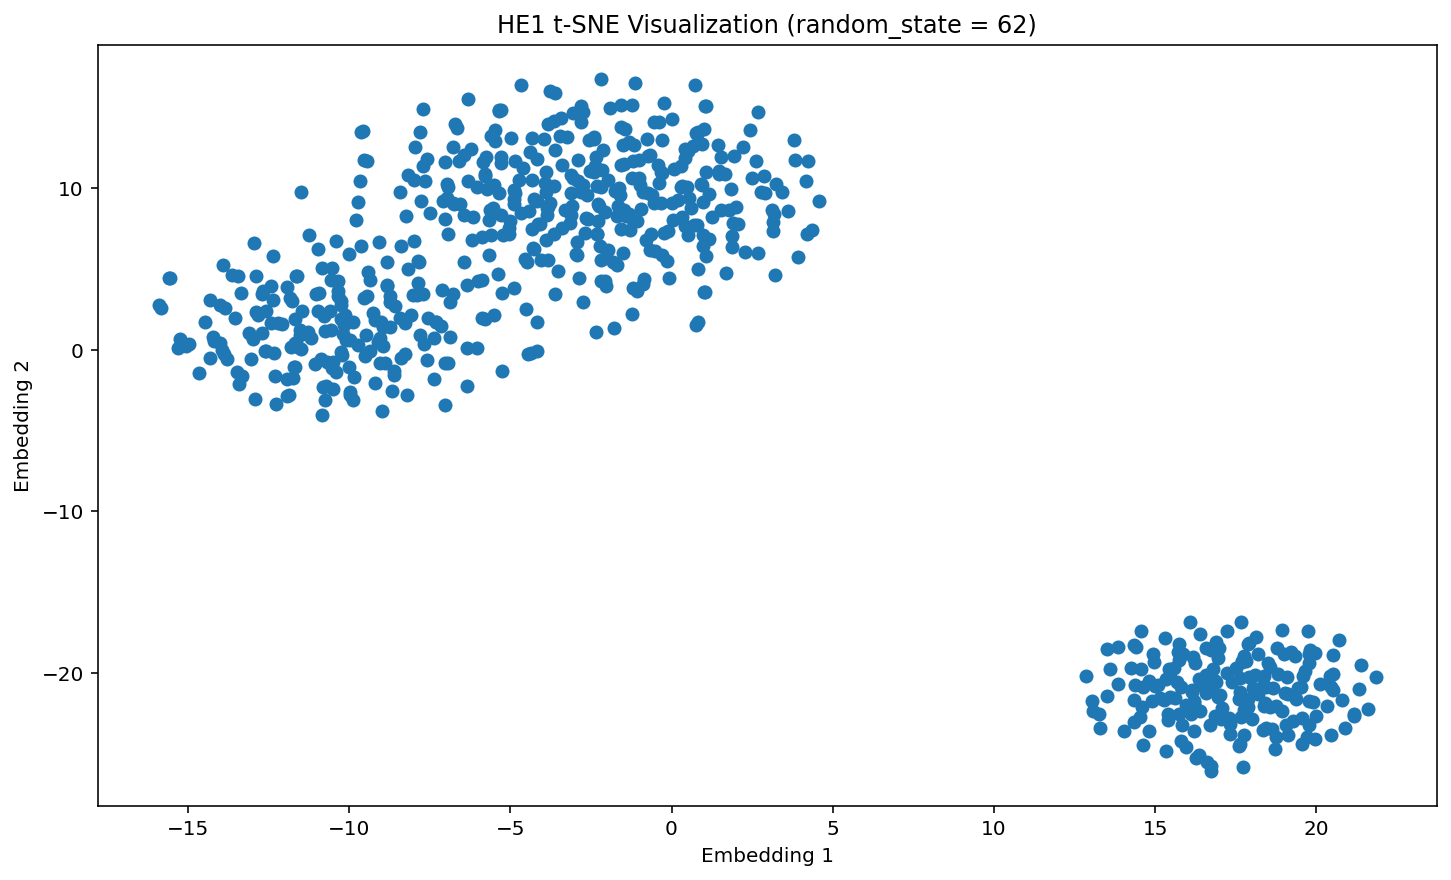

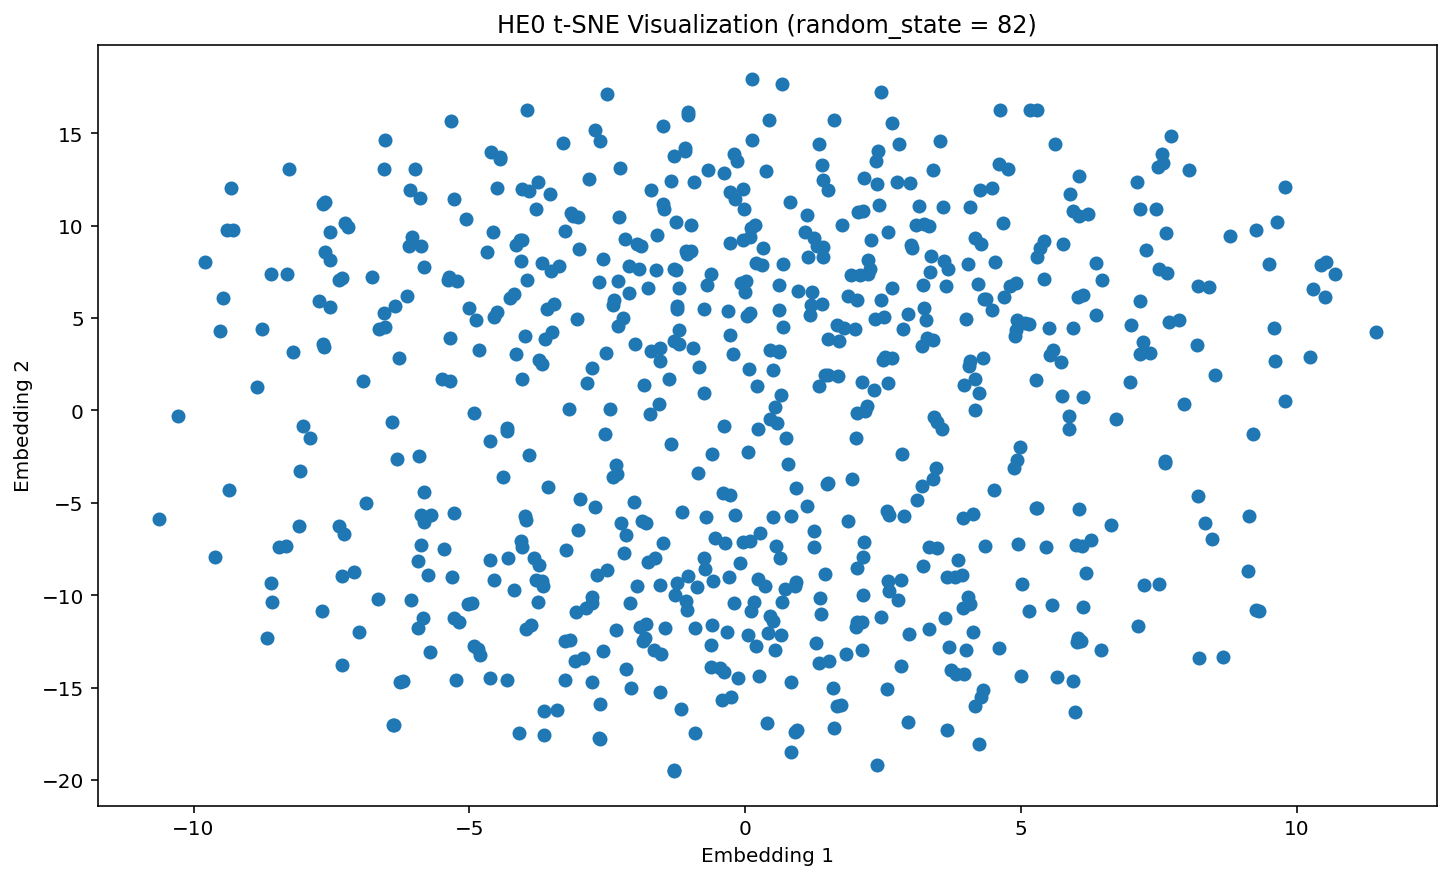

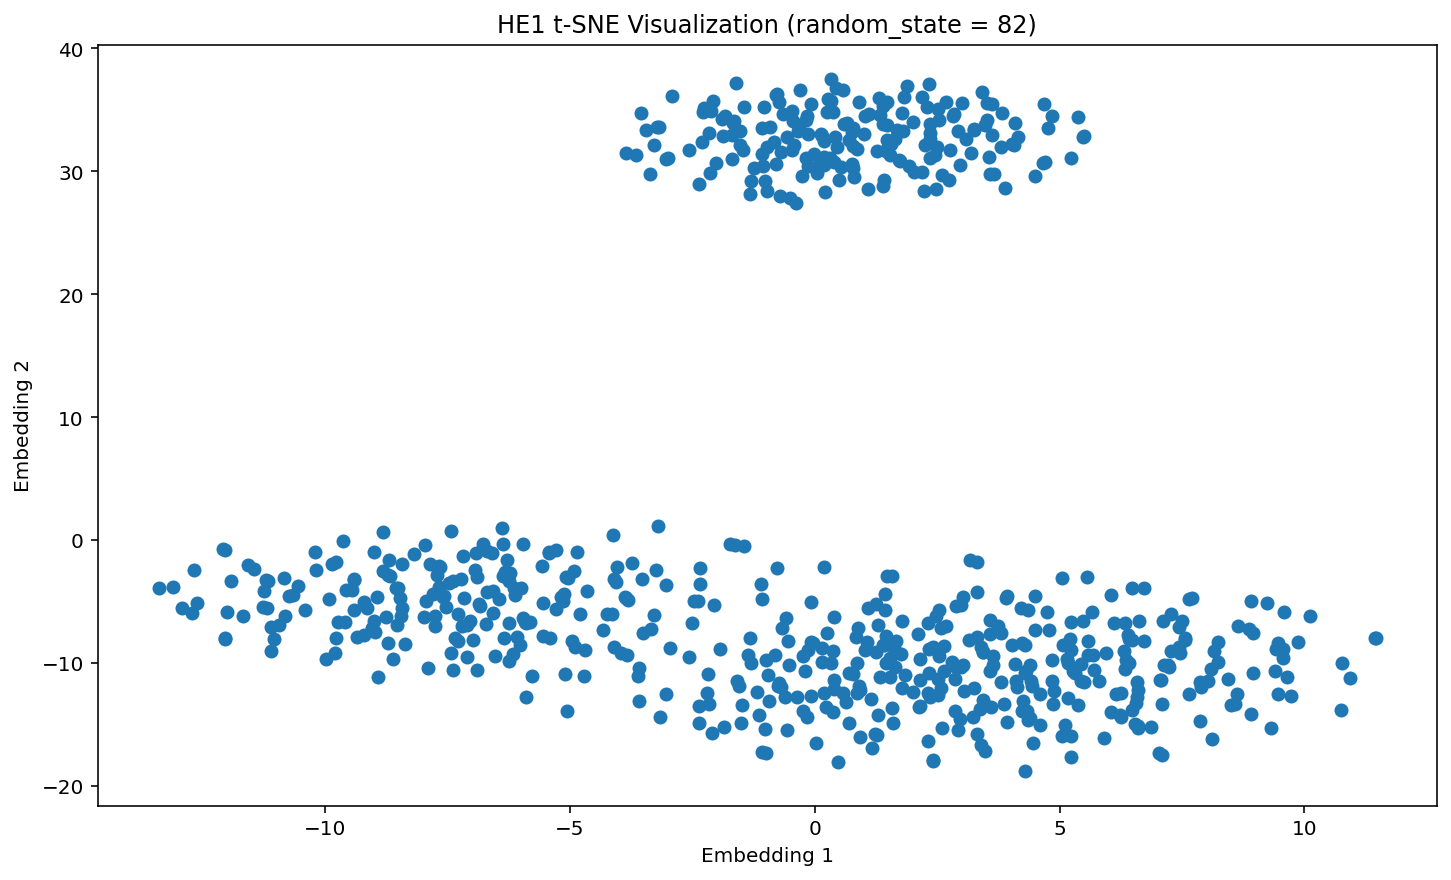

In [37]:
random_states = [42, 62, 82]
for i in random_states:
    RA_HE0_TSNE = TSNE(n_components=2 ,random_state=i).fit_transform(RA_HE0_df.T)
    RA_HE1_TSNE = TSNE(n_components=2 ,random_state=i).fit_transform(RA_HE1_df.T)
    plt.figure()
    plt.scatter(RA_HE0_TSNE[:, 0], RA_HE0_TSNE[:, 1])
    plt.title(f'HE0 t-SNE Visualization (random_state = {i})')
    plt.xlabel('Embedding 1')
    plt.ylabel('Embedding 2')
    plt.figure()
    plt.scatter(RA_HE1_TSNE[:, 0], RA_HE1_TSNE[:, 1])
    plt.title(f'HE1 t-SNE Visualization (random_state = {i})')
    plt.xlabel('Embedding 1')
    plt.ylabel('Embedding 2')


The clusters are more distinguishable and obvious for HE 1 while HE 0 clusters are more adjacent to each other. The clusters are dependent on the random states we selected. Different random states will produce different clusters.

And t-SNE is very slow.

### b. Comparing with PCA

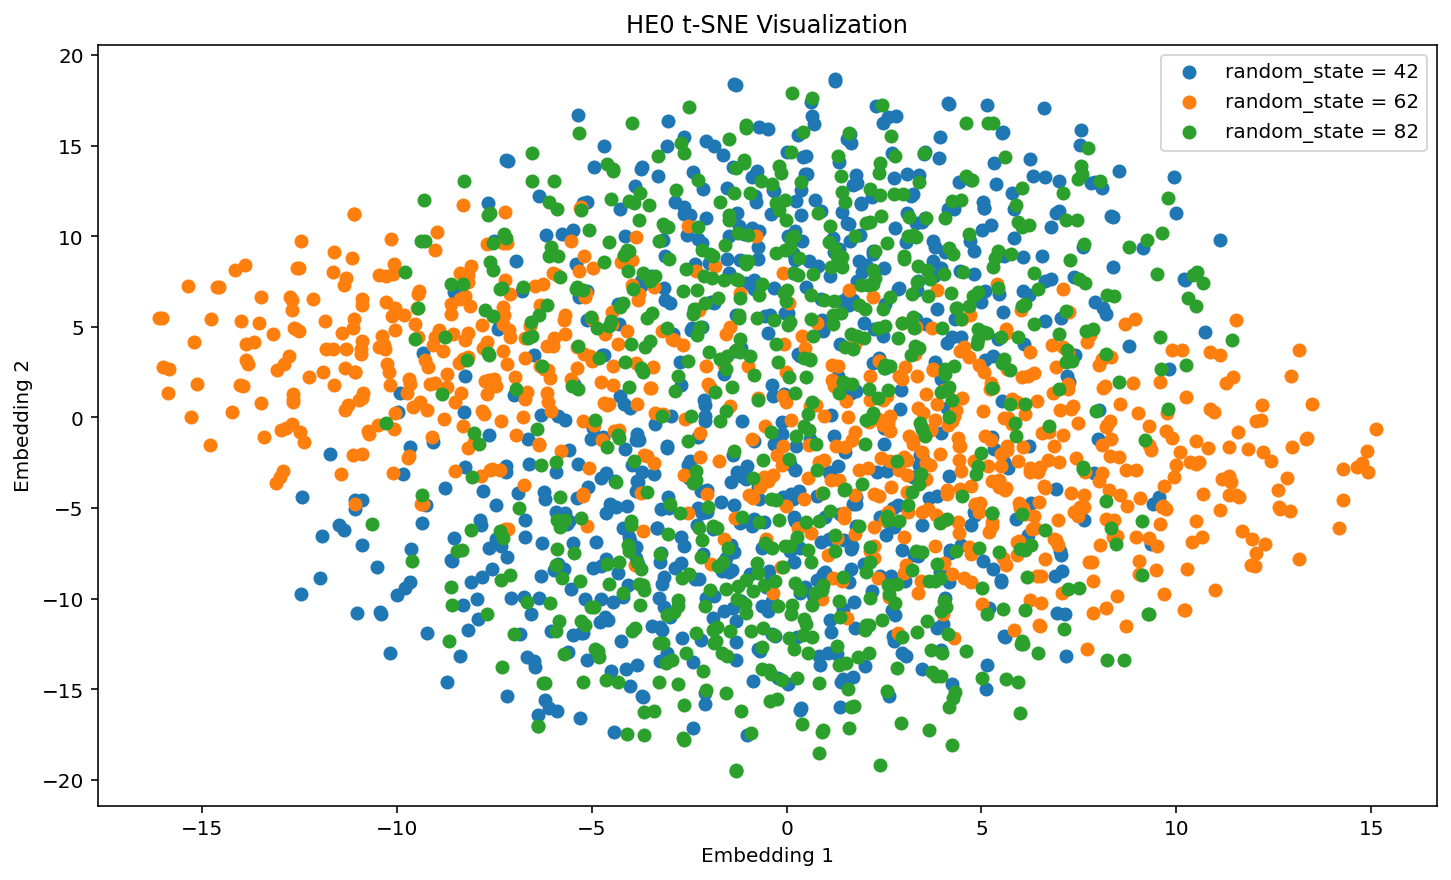

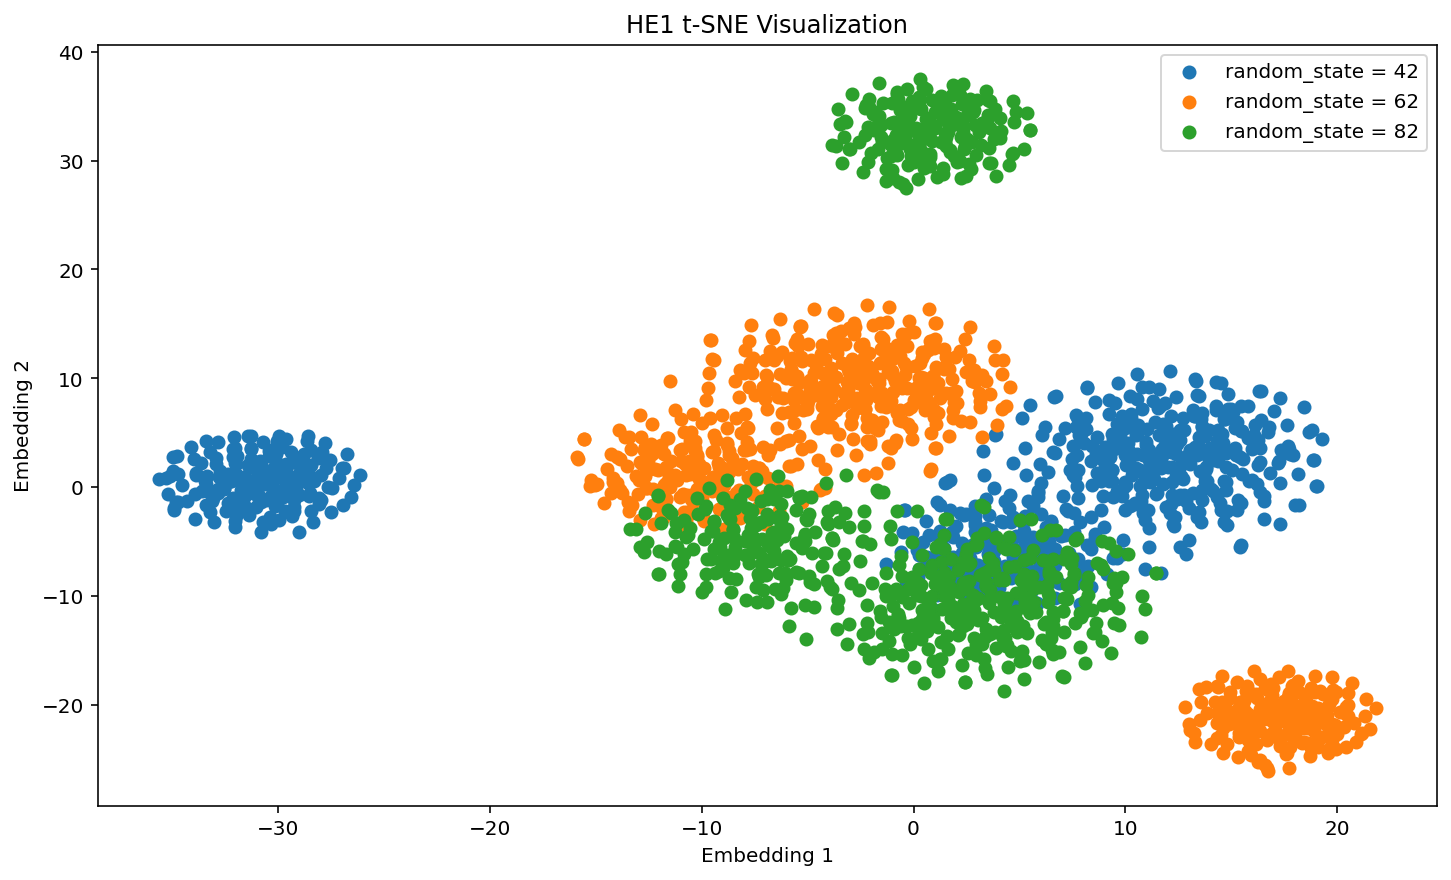

In [38]:
random_states = [42, 62, 82]
for i in random_states:
    RA_HE0_TSNE = TSNE(n_components=2 ,random_state=i).fit_transform(RA_HE0_df.T)
    label = 'random_state = {}'.format(i)
    plt.scatter(RA_HE0_TSNE[:, 0], RA_HE0_TSNE[:, 1], label = label)
    plt.title(f'HE0 t-SNE Visualization')
    plt.xlabel('Embedding 1')
    plt.ylabel('Embedding 2')
    plt.legend()

plt.figure()
for i in random_states:
    RA_HE1_TSNE = TSNE(n_components=2 ,random_state=i).fit_transform(RA_HE1_df.T)
    label = 'random_state = {}'.format(i)
    plt.scatter(RA_HE1_TSNE[:, 0], RA_HE1_TSNE[:, 1], label = label)
    plt.title(f'HE1 t-SNE Visualization')
    plt.xlabel('Embedding 1')
    plt.ylabel('Embedding 2')
    plt.legend()

One key difference is the runtime. The computation time for t-SNE is longer than PCA. And t-SNE is dependent on the random states selected, as different random states will result differently.

Similarity is both algorithms are used to reduce the dimension of the data while PCA maximizes the variance, t-SNE constructs a probability distribution for the high-dimensional samples in such a way that similar samples have a high likelihood of being picked and dissimilar points have an small likelihood of being picked.


## 3. Clustering

### a. K-Means

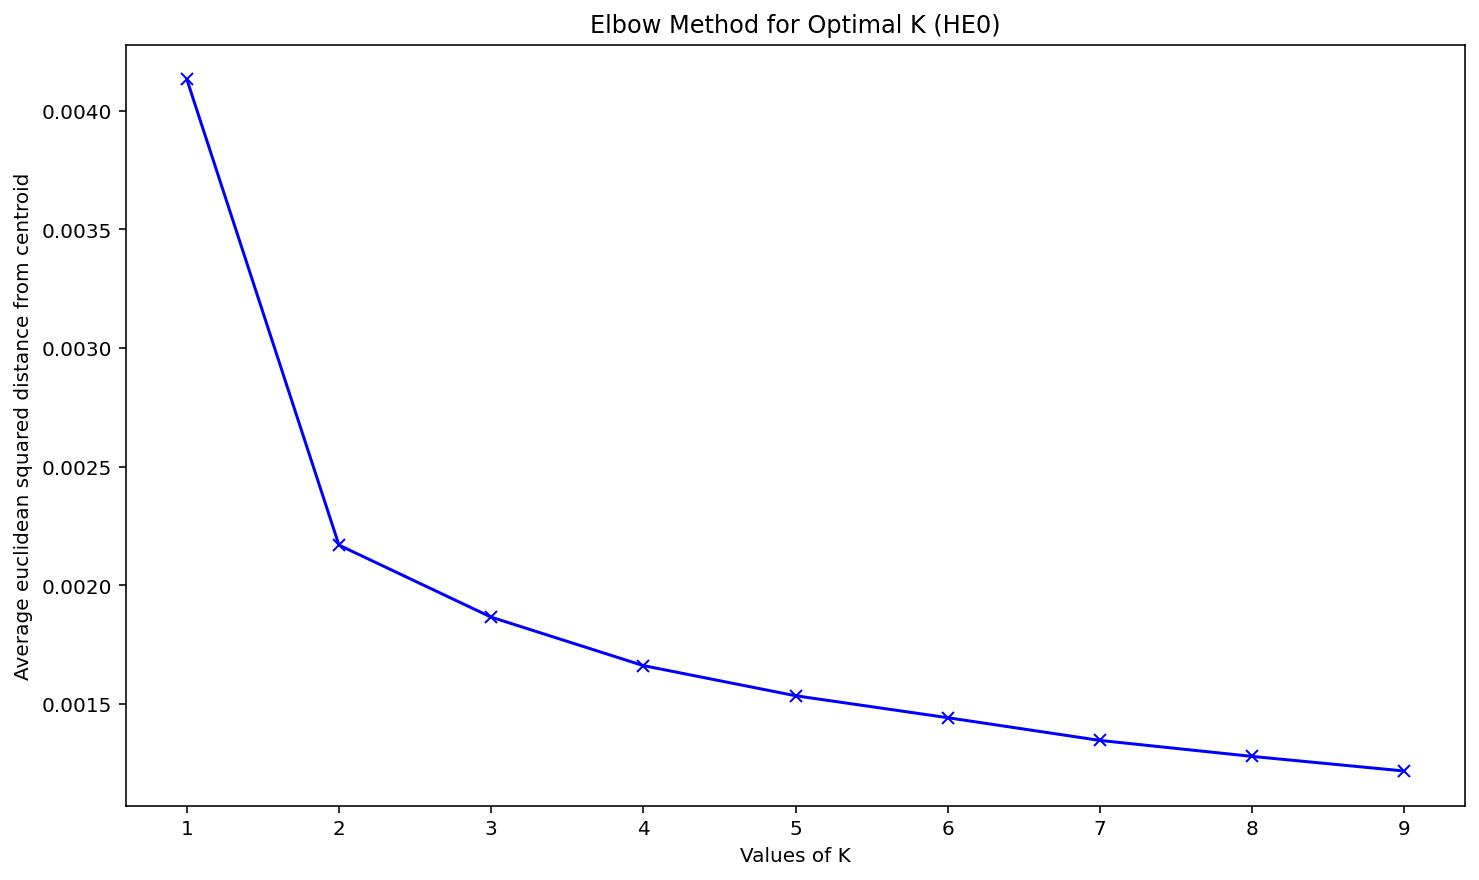

For HE 0, K = 2 is the elbow of the plot, so K = 2 is the optimal K


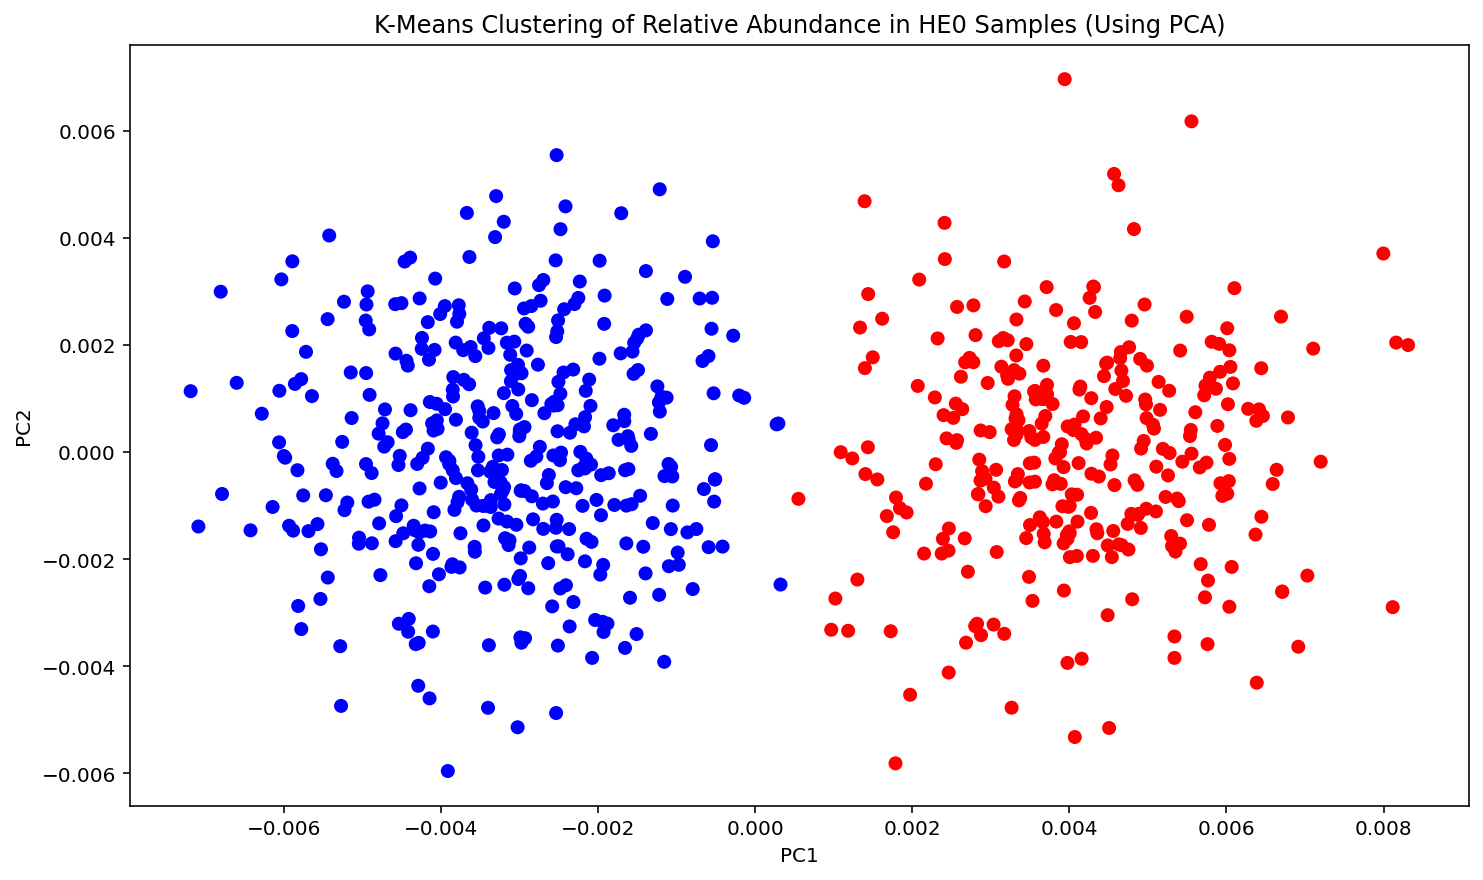

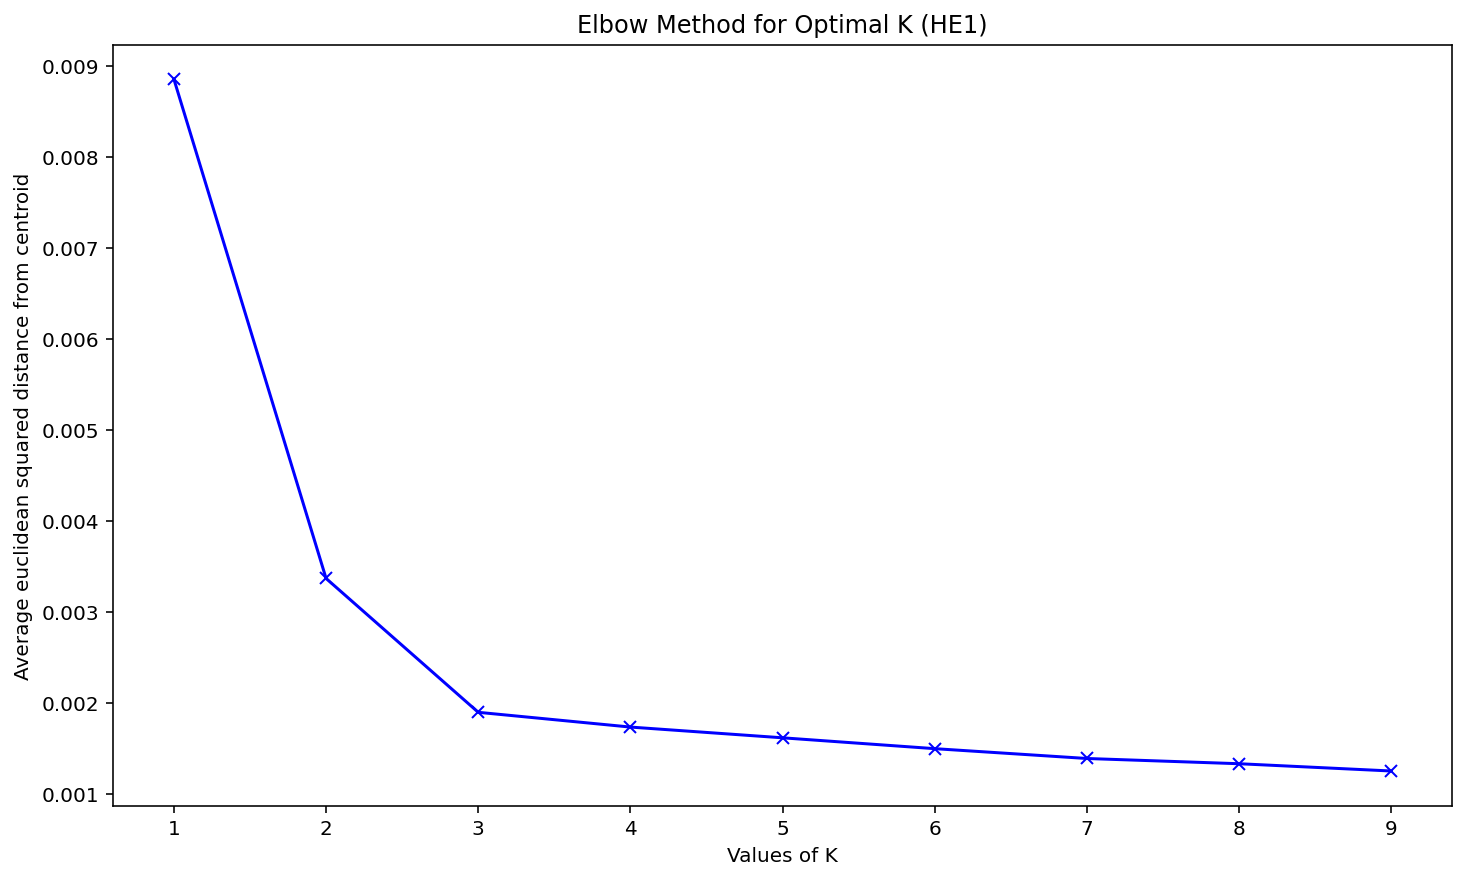

For, HE 1, K = 3 is the elbow of the plot, so K = 3 is the optimal K


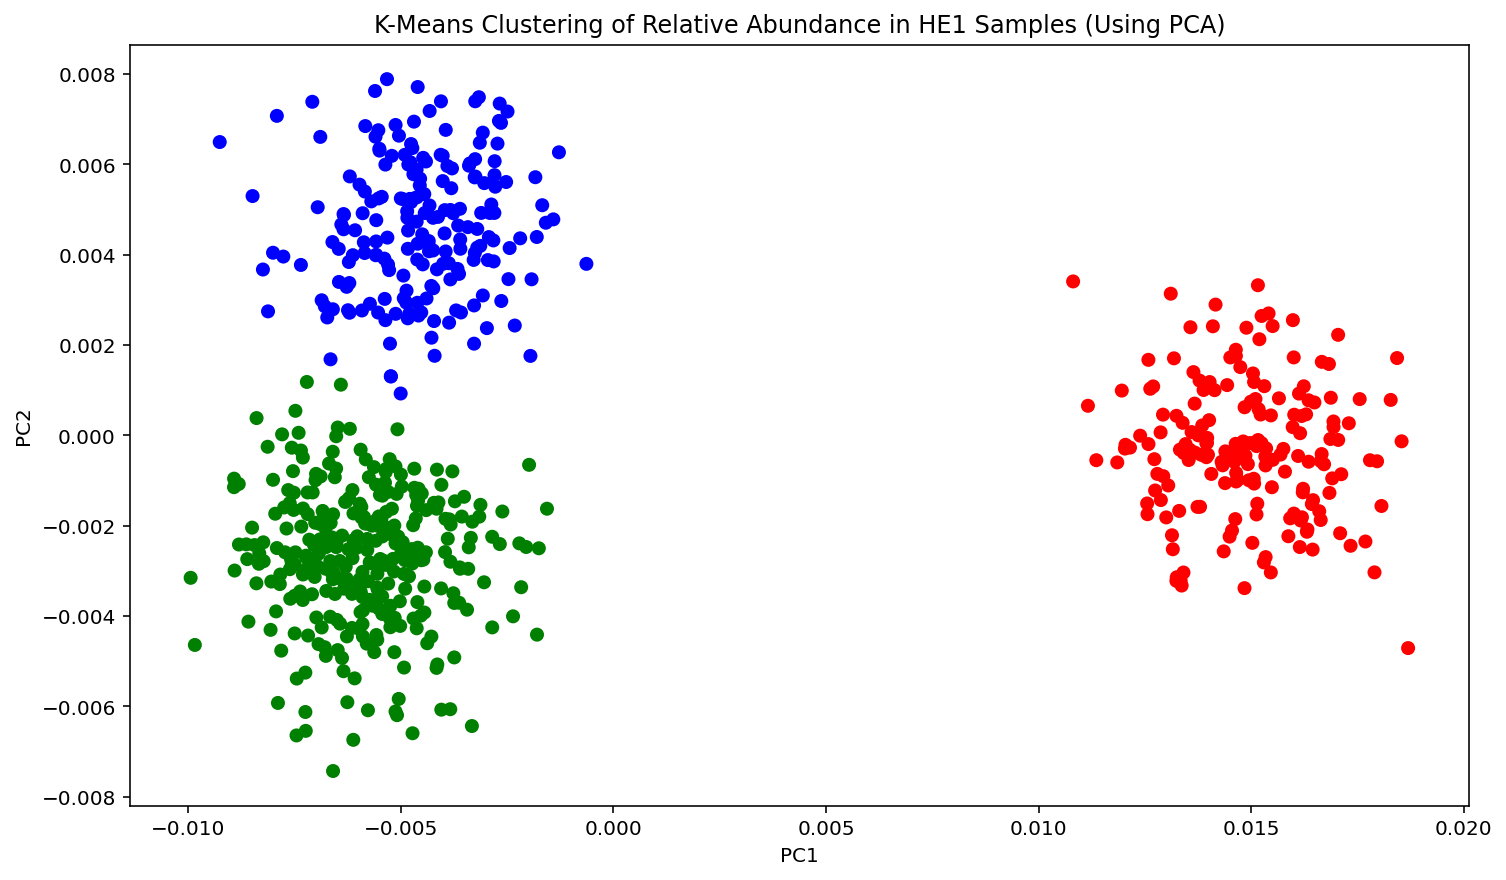

In [39]:
# HE 0
from matplotlib.colors import ListedColormap
from sklearn import metrics 
from scipy.spatial.distance import cdist 

distortions = [] 
K = range(1,10) 
  
for k in K: 
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(RA_HE0_2pc)     
    distortions.append(sum(np.min(cdist(RA_HE0_2pc, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / RA_HE0_2pc.shape[0]) 
    
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Average euclidean squared distance from centroid') 
plt.title('Elbow Method for Optimal K (HE0)')
plt.show() 

print('For HE 0, K = 2 is the elbow of the plot, so K = 2 is the optimal K')

kmeans_HE0 = KMeans(n_clusters = 2)
cluster_idx_HE0 = kmeans_HE0.fit_predict(RA_HE0_2pc)
plt.scatter(RA_HE0_2pc[:,0], RA_HE0_2pc[:,1], c=cluster_idx_HE0, cmap=ListedColormap(['r','b']))
plt.title('K-Means Clustering of Relative Abundance in HE0 Samples (Using PCA)');
plt.xlabel('PC1');
plt.ylabel('PC2');

# HE 1
distortions = [] 
K = range(1,10) 
  
for k in K: 
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(RA_HE1_2pc)     
    distortions.append(sum(np.min(cdist(RA_HE1_2pc, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / RA_HE1_2pc.shape[0]) 
plt.figure()
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Average euclidean squared distance from centroid') 
plt.title('Elbow Method for Optimal K (HE1)') 
plt.show() 

print('For, HE 1, K = 3 is the elbow of the plot, so K = 3 is the optimal K')

kmeans_HE1 = KMeans(n_clusters = 3)
cluster_idx_HE1 = kmeans_HE1.fit_predict(RA_HE1_2pc)
plt.scatter(RA_HE1_2pc[:,0], RA_HE1_2pc[:,1], c=cluster_idx_HE1, cmap=ListedColormap(['r','b','g']))
plt.title('K-Means Clustering of Relative Abundance in HE1 Samples (Using PCA)');
plt.xlabel('PC1');
plt.ylabel('PC2');

### b. GMM

In [40]:
# Plot the confidence ellipsoids of a mixture of two Gaussians obtained with Expectation Maximisation
# https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm.html#sphx-glr-auto-examples-mixture-plot-gmm-py
import itertools
from scipy import linalg
import matplotlib as mpl
from sklearn import mixture

def plot_results(X, Y_, means, covariances, index, title):
    plt.figure()
    color_iter = itertools.cycle(['cornflowerblue', 'gold', 'darkorange', 'navy', 'c'])
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        label = f'Cluster {i+1}'
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], color=color, label = label)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xticks(())
    plt.yticks(())
    plt.title(title)
    plt.legend()

From visual inspection of the 2-D Scatter Plots with the PCA components, we find that there are 2 clusters for HE0 samples, and 3 clusters for HE1 samples, so n_components = 2 for HE0 as well as n_components = 3 for HE1


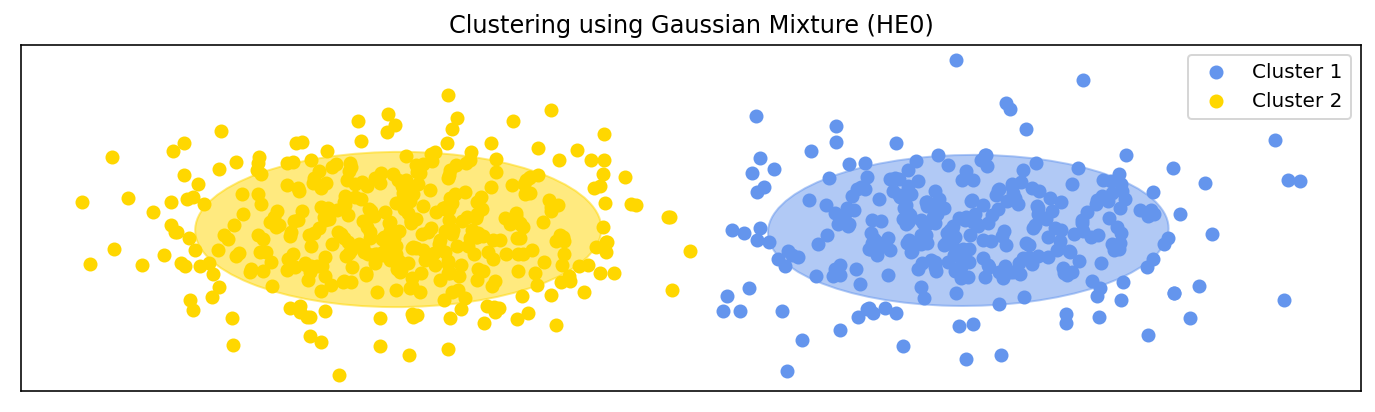

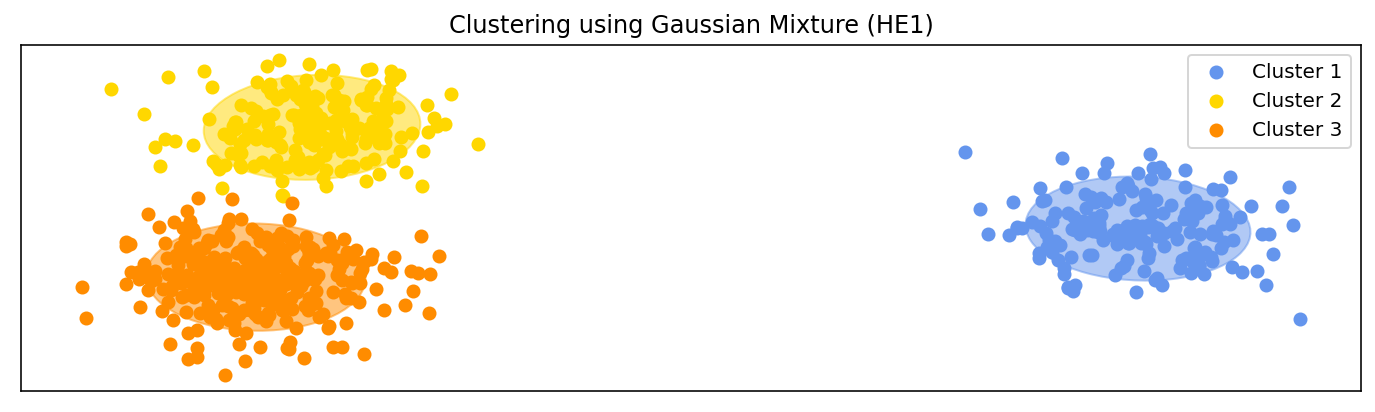

In [41]:
gmm = GaussianMixture(n_components=2, covariance_type='full').fit(RA_HE0_2pc)
plot_results(RA_HE0_2pc, gmm.predict(RA_HE0_2pc), gmm.means_, gmm.covariances_, 0, 'Clustering using Gaussian Mixture (HE0)')

gmm = GaussianMixture(n_components=3, covariance_type='full').fit(RA_HE1_2pc)
plot_results(RA_HE1_2pc, gmm.predict(RA_HE1_2pc), gmm.means_, gmm.covariances_, 1, 'Clustering using Gaussian Mixture (HE1)')

# cluster_idx_HE0 = gmm.fit_predict(RA_HE0_2pc)
# plt.scatter(RA_HE0_2pc[:, 0], RA_HE0_2pc[:, 1], c=cluster_idx_HE0)

# cluster_idx_HE0 = kmeans_HE0.fit_predict(RA_HE0_2pc)
# plt.scatter(RA_HE0_2pc[:,0], RA_HE0_2pc[:,1], c=cluster_idx_HE0, cmap=ListedColormap(['r','b']))
print('From visual inspection of the 2-D Scatter Plots with the PCA components, we find that there are 2 clusters for HE0 samples, and 3 clusters for HE1 samples, so n_components = 2 for HE0 as well as n_components = 3 for HE1')

### c. Single and Complete Linkage Hierarchical

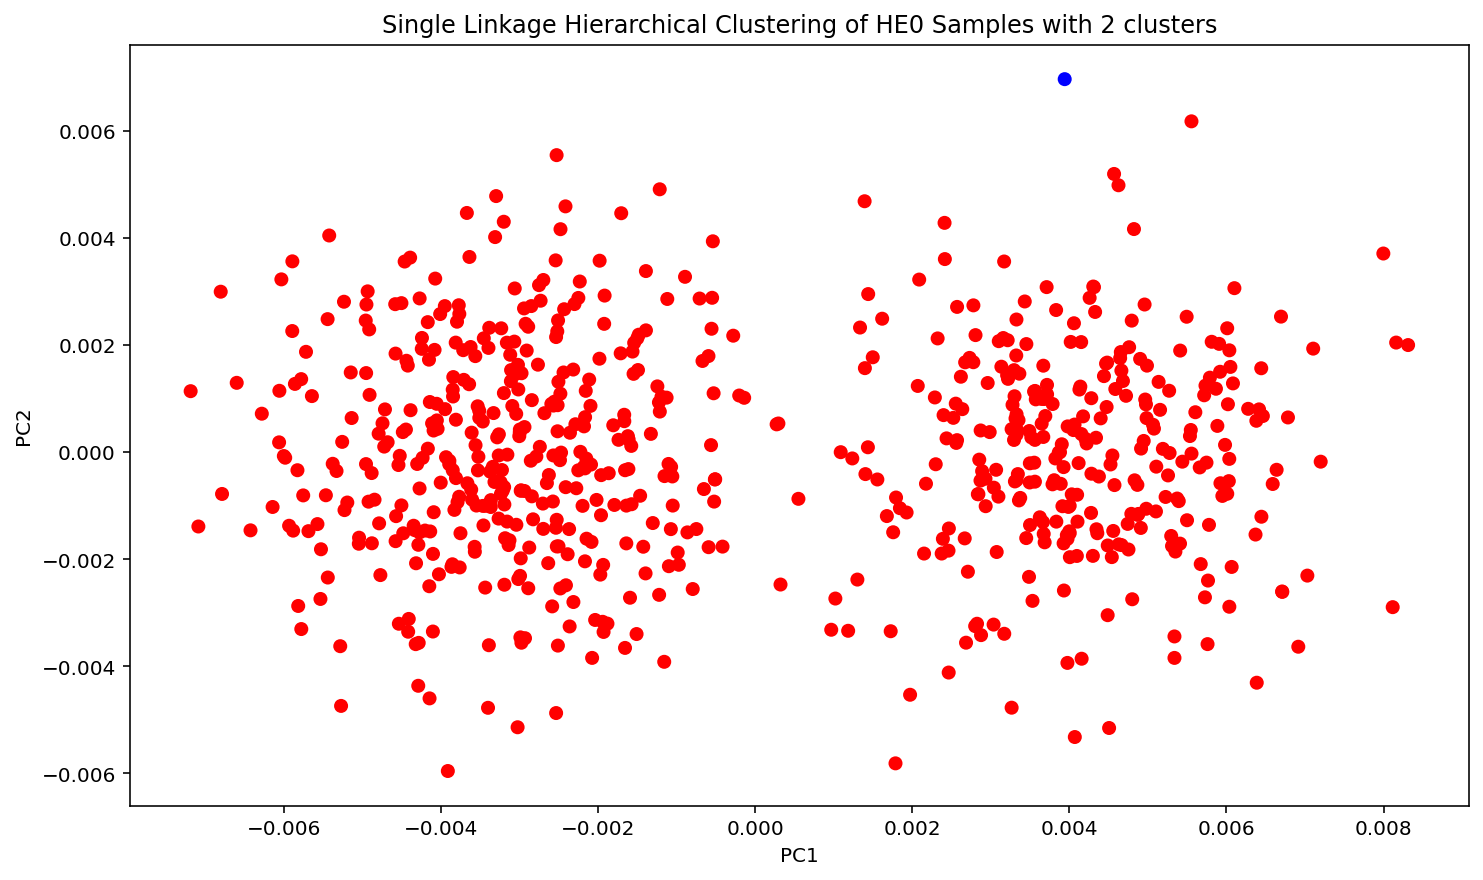

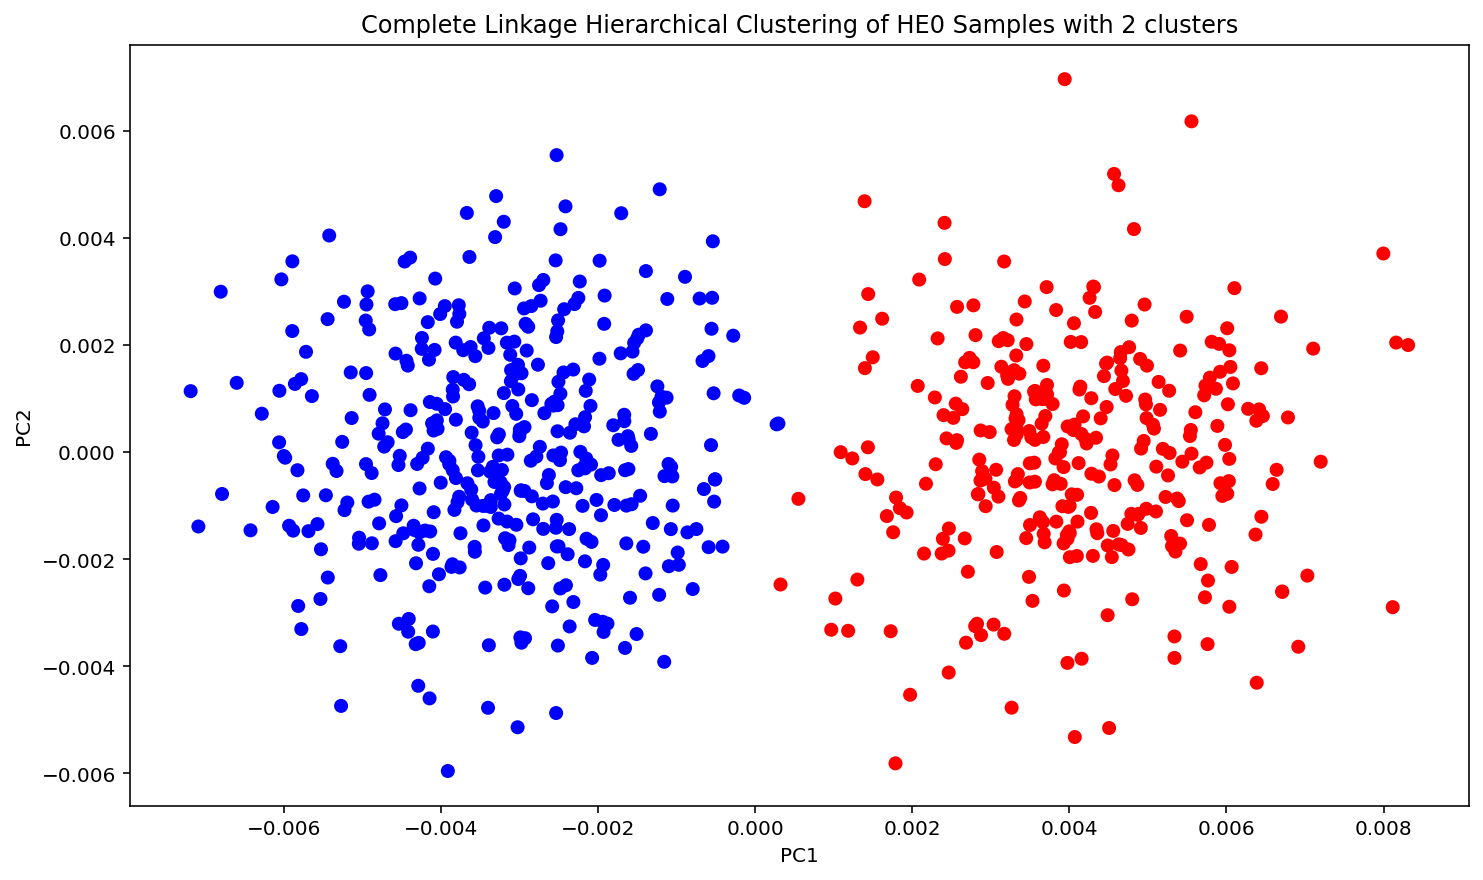

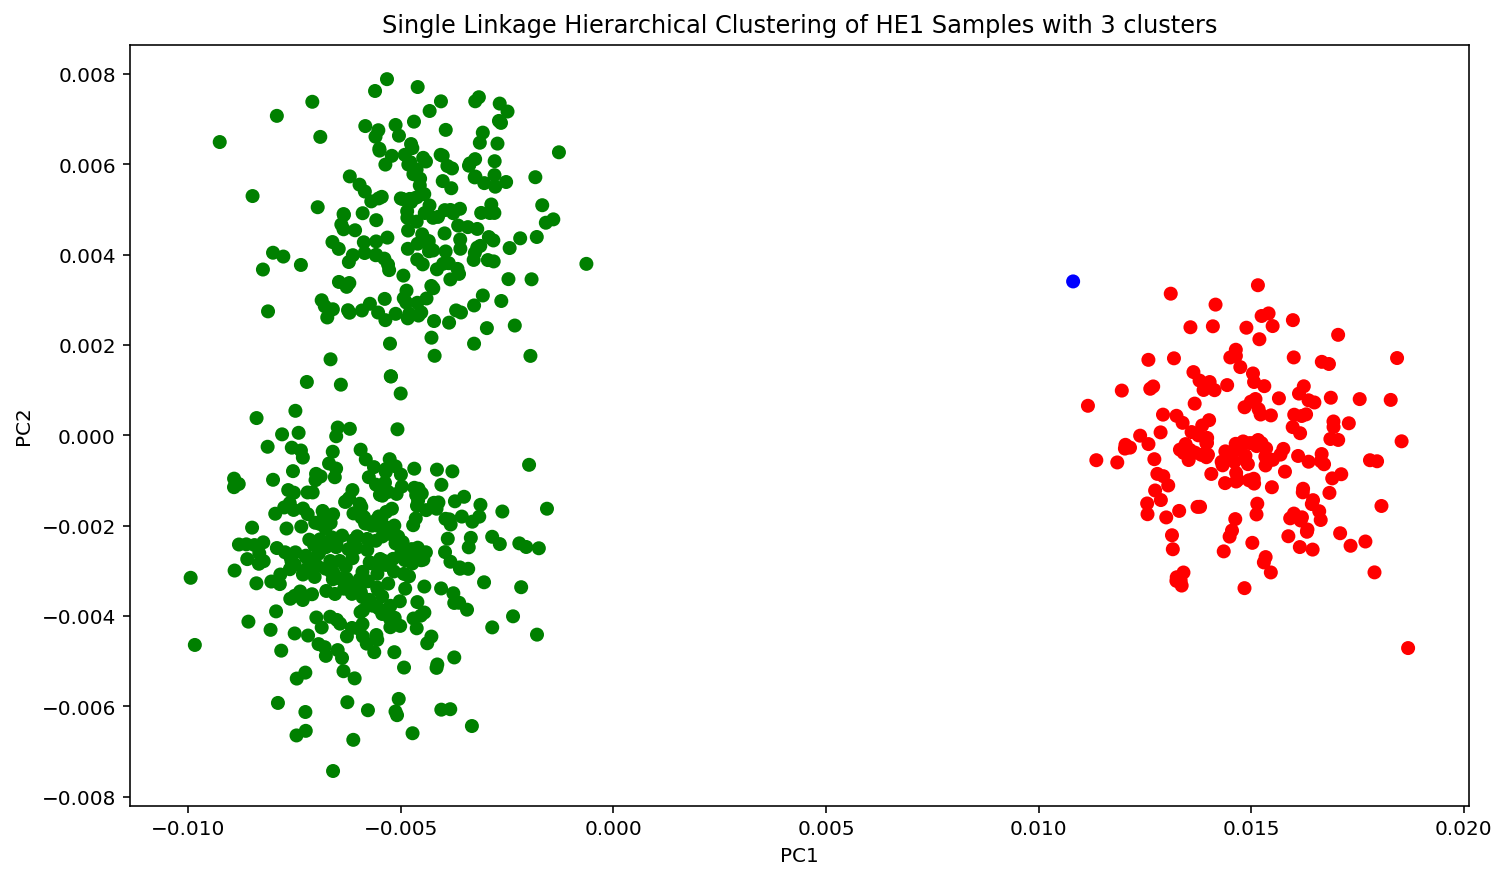

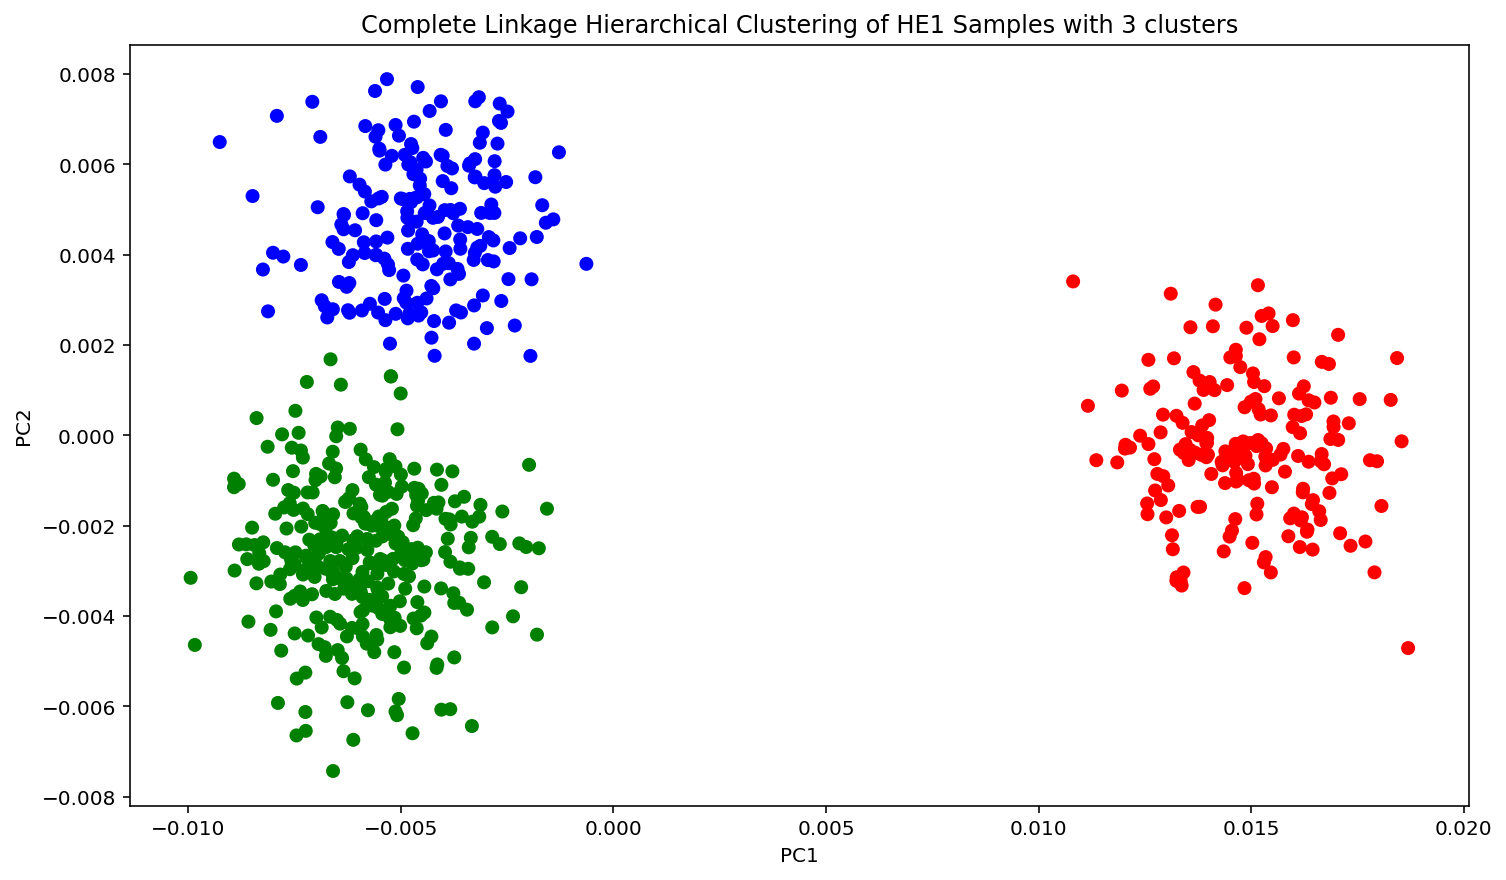

In [42]:
from sklearn.cluster import AgglomerativeClustering
# from scipy.cluster.hierarchy import linkage, dendrogram


# HE0
# single
hier_model = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='single')
hier_clustered = hier_model.fit_predict(RA_HE0_2pc)
plt.scatter(RA_HE0_2pc[:,0], RA_HE0_2pc[:,1], c=hier_clustered, cmap=ListedColormap(['r','b']))
plt.title('Single Linkage Hierarchical Clustering of HE0 Samples with 2 clusters');
plt.xlabel('PC1');
plt.ylabel('PC2');

# complete
plt.figure()
hier_model = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='complete')
hier_clustered = hier_model.fit_predict(RA_HE0_2pc)
plt.scatter(RA_HE0_2pc[:,0], RA_HE0_2pc[:,1], c=hier_clustered, cmap=ListedColormap(['r','b']))
plt.title('Complete Linkage Hierarchical Clustering of HE0 Samples with 2 clusters');
plt.xlabel('PC1');
plt.ylabel('PC2');

print()
# HE1
# single
plt.figure()
hier_model = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='single')
hier_clustered = hier_model.fit_predict(RA_HE1_2pc)
plt.scatter(RA_HE1_2pc[:,0], RA_HE1_2pc[:,1], c=hier_clustered, cmap=ListedColormap(['r', 'g', 'b']))
plt.title('Single Linkage Hierarchical Clustering of HE1 Samples with 3 clusters');
plt.xlabel('PC1');
plt.ylabel('PC2');

# complete
plt.figure()
hier_model = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='complete')
hier_clustered = hier_model.fit_predict(RA_HE1_2pc)
plt.scatter(RA_HE1_2pc[:,0], RA_HE1_2pc[:,1], c=hier_clustered, cmap=ListedColormap(['r', 'g', 'b']))
plt.title('Complete Linkage Hierarchical Clustering of HE1 Samples with 3 clusters');
plt.xlabel('PC1');
plt.ylabel('PC2');

### d. Single vs Complete Link Hierarchical Clustering

**Single Link:**
HE0: There are 2 clusters, but one cluster is formed with only one data point. The reason for this weird clustering is that the data for HE0 has many outliers. Single link is not good at clustering datasets with outliers.
HE1: There are 3 clusters, but one cluster is formed with only one data point. The reason for this weird clustering is that the data for HE0 has many outliers. Single link is not good at clustering datasets with outliers.

**Complete Link:**
HE0: There are 2 well partitioned clusters. Complete link is robust to outliers, and thus it could cluster such a dataset with outliers.
HE1: There are 3 well partitioned clusters. Complete link is robust to outliers, and thus it could cluster such a dataset with outliers.

#We observe the common problem of single link clustering being too sensitive to outliers. The outlier in both cases (HE0 and HE1) forms its own cluster (the blue dot).
#The complete like clustering performed better than the single link clustering in such a dataset with outliers.

Single linkage hierarchical clustering maximizes the minimum distance between data points in the clusters while complete linkage clustering maximizes the maximum distance between data points in the clusters. \
Single linkage and complete linkage clusterings have different behavior on our dataset. Complete linkage method was able to identify the clusters correctly but single linkage method failed to do so. Single linkage method labelled a data point that was far from other points in the cluster as a single cluster and wasn't able to separate clusters with points that are close. The noise and outliers in our data caused the single linkage method to behave differently.

### e. Comparing Clustering Techniques

We can observe that K-Means, GMM and Complete-link clustering performed well and had similar assignments of the data points, clearly forming 2 clusters for HE0 and 3 clusters for HE1. Single-link clustering assigned single-point clusters and thus is not prefered.

Since the clustering groups of K-Means, GMM and Complete-link clustering are very similar (expect a few points lying at inter-cluster boundaries), we choose K-means clustering becase it's easier to compute.

### f. What do Clusters Represent
This question is asking you to give some intuition/explanation biologically on what the clusters may signify. You need only use the biological information given in the MP document to make your educated guess.

In context, the clusters represent groups of samples within HE0 or HE1 which are "closely related" based on a linear combination of relative abundance of microbio. The clusters here represent patterns which are observed after performing PCA on a large dataset, and different PCs cover different linear combination of microbiome along which the variance of the data is maximum.

One possible factor is some other undiscovered condition that follows with liver cirrhosis just like HE.

### g. Deciding on Number of Clusters

We picked the number of clusters based on the 2-d visualization of our data points. We are visualizing the data points only with the first 2 PCs. For HE1 dataset, this explains more than 30% variance in the data and the decision made on visualization may be accurate enough. However in the HE0 dataset, using the first 2 PCs only explains about 10% of the total variance and thus partitioning data into 2 clusters might inaccurate.
Also, if the clusters are being formed based on external factors after the sample was being taken, the clusters may not be accurate as well.

# Task 4: Interpreting Results

## 1. Identify Microbes with Altered Abundance Levels

### a. Determine if each HE1 Subpopulation shows altered abundance levels

Analysis Procedure:

We are comparing the three clusters formed in HE1 with the two clusters formed in HE0. Since it is difficult to compare each individual point in a cluster we use the mean of the points in the cluster to represent each subpopulation.

Step 1: Use the clustering result from the K-Means clustering. For each clustered subpopulation in both HE0 and HE1, calculate the mean of the samples in the subpopulation for all 149 microbes.

Step 2: Visualize the clusters and compare the relative abundances of the cluster means. 

Step 3: For each HE1 cluster, observe if any of its abundance levels is significantly different than all of the HE0 clusters. Identify the subpopulations with significantly altered microbes abundances.

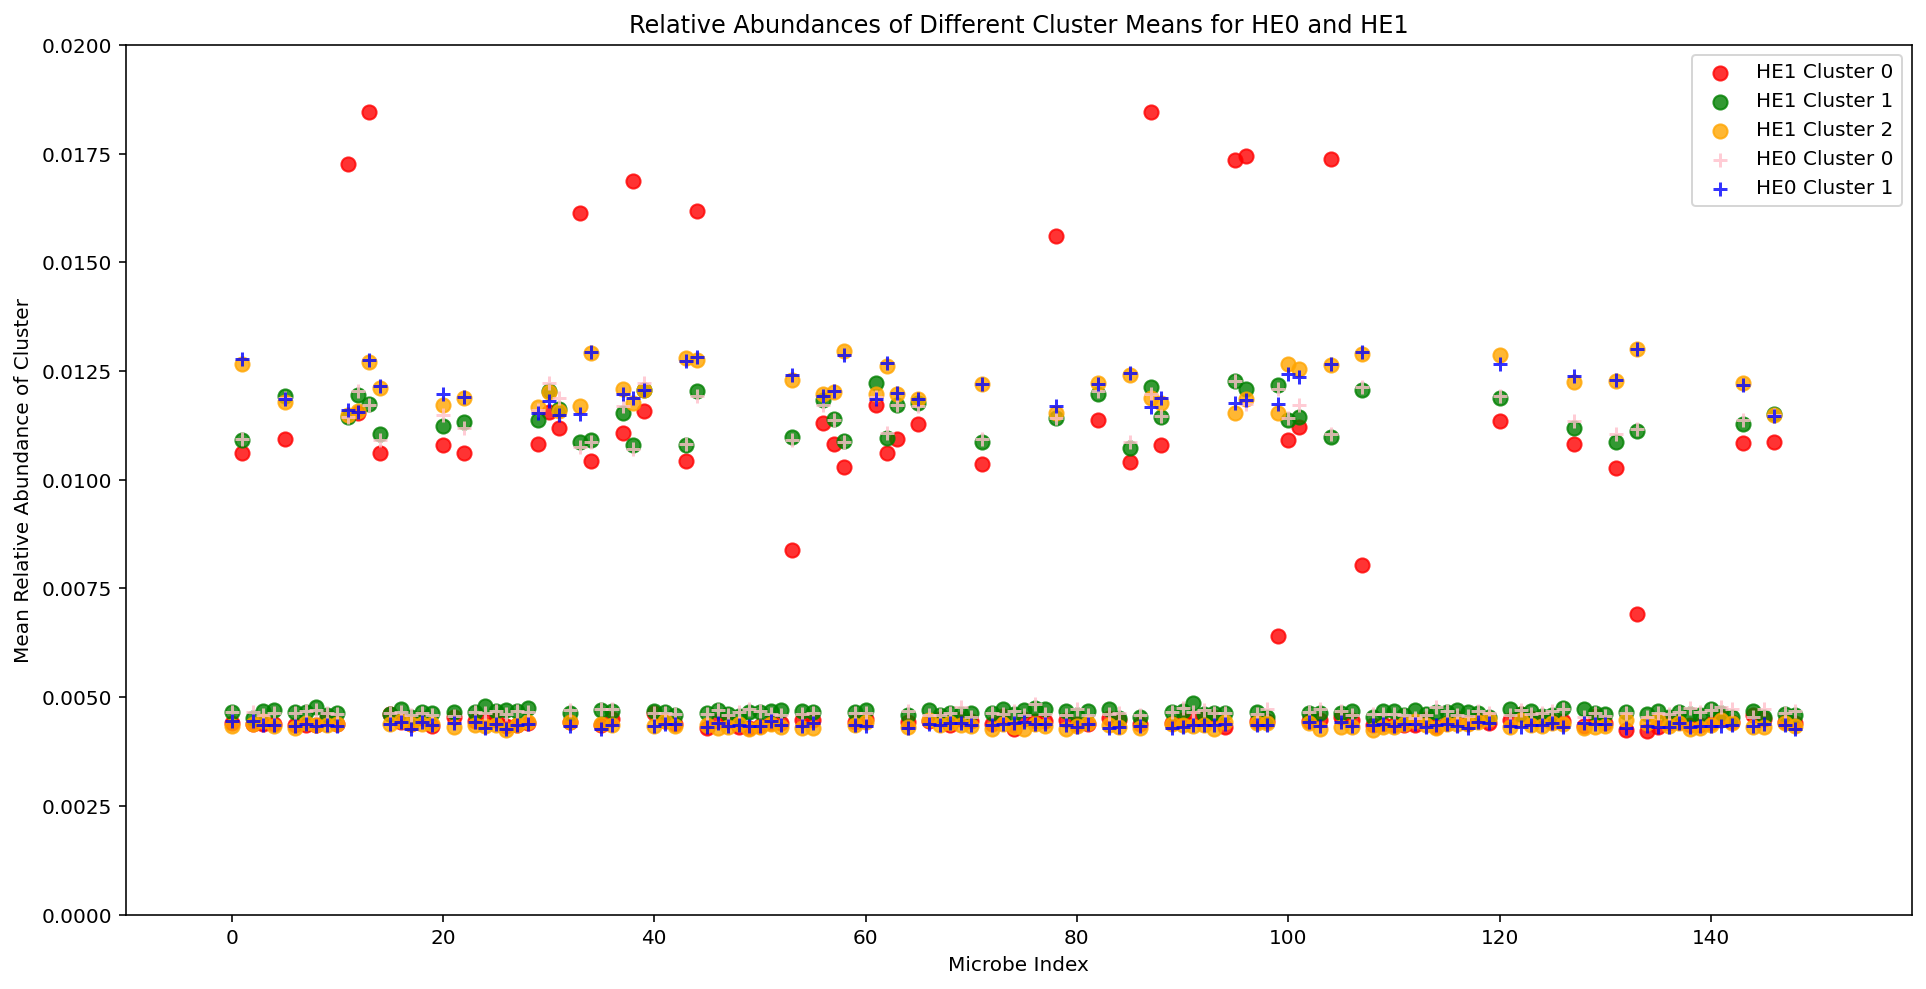

In [50]:
HE0_mean_df = pd.DataFrame(columns=RA_HE0_df.index)
HE1_mean_df = pd.DataFrame(columns=RA_HE0_df.index)

# Calculate sample means of all microbe for each cluster in HE0 and HE1
for cluster_i in set(cluster_idx_HE0):
    HE0_mean_df.loc[cluster_i] = RA_HE0_df.T[cluster_idx_HE0 == cluster_i].mean()
    
for cluster_i in set(cluster_idx_HE1):
    HE1_mean_df.loc[cluster_i] = RA_HE1_df.T[cluster_idx_HE1 == cluster_i].mean()
    
# Plot the sample means
plt.figure(figsize = (16,8))
colors = ['red','green','orange']
for i in range(len(set(cluster_idx_HE1))):
    plt.scatter(range(HE1_mean_df.shape[1]), HE1_mean_df.loc[i], marker = "o", s = 50, color = colors[i], label = f'HE1 Cluster {i}', alpha=0.8)
    
colors = ['pink','blue', 'green']
for i in range(len(set(cluster_idx_HE0))):
    plt.scatter(range(HE0_mean_df.shape[1]), HE0_mean_df.loc[i], marker = "+", s = 50, color = colors[i], label = f'HE0 Cluster {i}', alpha=0.8)
    
plt.legend()
plt.xlabel('Microbe Index')
plt.ylabel('Mean Relative Abundance of Cluster')
plt.title('Relative Abundances of Different Cluster Means for HE0 and HE1')
plt.xlim([-10, 159])
plt.ylim([0,0.02])
plt.legend(loc = 'best')
plt.show()

In [44]:
# For each cluster in HE1, check to see if it has microbes
# with relative abundance level significantly different than any of the HE0 clusters
# if the abundances vary by 10% we say they are significantly different
for i in range(len(set(cluster_idx_HE1))):
    for microbe in HE1_mean_df.columns:
        matched = False
        for j in range(len(set(cluster_idx_HE0))):
            if (HE1_mean_df.loc[i, microbe] - HE0_mean_df.loc[j, microbe]) / HE0_mean_df.loc[j, microbe] < 0.1:
                matched = True
                break
        if not matched:
            print(f'Cluster {i} in HE1 samples has significantly altered microbe abundance')
            break

Cluster 0 in HE1 samples has significantly altered microbe abundance


From the above analysis we know that cluster 1 of HE1 samples has microbes with significantly altered abundances.

Also, From the plot above we can tell that:

HE1 Cluster 1 (green circle) maps to HE0 Cluster 0 (pink cross)

HE1 Cluster 2 (orange circle) maps to HE0 Cluster 1 (blue cross)

HE1 Cluster 0 (red circle) has microbes with significantly altered abundances that lie far from the HE0 clusters

### b. Identify Most Similar HE0 Clusters to Affected HE1 Clusters

To see which HE0 cluster HE1 Cluster0 is more similar to, we calculate the distances using the sum of squared error of the abundance means between it and the two HE0 clusters.

In [48]:
se_cluster_0 = ((HE1_mean_df.loc[0] - HE0_mean_df.loc[0]) **2).sum()
se_cluster_1 = ((HE1_mean_df.loc[0] - HE0_mean_df.loc[1]) **2).sum()

print(f'd(HE1 Cluster 0, HE0 Cluster 0) = {se_cluster_0}')
print(f'd(HE1 Cluster 0, HE0 Cluster 1) = {se_cluster_1}')

d(HE1 Cluster 0, HE0 Cluster 0) = 0.0004113865419626202
d(HE1 Cluster 0, HE0 Cluster 1) = 0.0004364532630837121


Comparing the distances between HE1 cluster 0 and the two clusters in HE0, we see that HE1 Cluster 0 (red circle) with significantly altered microbes is more similar to HE0 Cluster 0 (pink cross).

### c. Identify Microbes with Significantly Altered Relative Abundance

In [51]:
import scipy
# Get altered subpopulation of HE1 samples (cluster 0) and the corresponding subpopulation in HE0 (cluster 0)
subpop_HE1_df = RA_HE1_df.iloc[:, cluster_idx_HE1 == 0]
subpop_HE0_df = RA_HE0_df.iloc[:, cluster_idx_HE0 == 0]

# For each microbe test the similarity of its distribution in the two subpopulations
altered_microbes = []
alpha_level = 0.0000025
for microbe in subpop_HE1_df.index:
    _, p = scipy.stats.ks_2samp(subpop_HE1_df.loc[microbe], subpop_HE0_df.loc[microbe])
    if p < alpha_level:
        altered_microbes.append(microbe)

print(f'The following are identified microbes with significantly altered abundance (total {len(altered_microbes)} microbes):')
print('\n'.join(altered_microbes))

The following are identified microbes with significantly altered abundance (total 19 microbes):
Actinobacteria_Actinobacteria_Actinomycetales_Corynebacteriaceae
Actinobacteria_Actinobacteria_Actinomycetales_Nakamurellaceae
Actinobacteria_Actinobacteria_Actinomycetales_Propionibacteriaceae
Bacteroidetes_Bacteroidia_Bacteroidales_Bacteroidales_incertae_sedis
Bacteroidetes_Flavobacteriia_Flavobacteriales_Cryomorphaceae
Bacteroidetes_Sphingobacteriia_Sphingobacteriales_Sphingobacteriaceae
Chrysiogenetes_Chrysiogenetes_Chrysiogenales_Chrysiogenaceae
Firmicutes_Bacilli_Bacillales_Bacillales_Incertae Sedis XI
Firmicutes_Bacilli_Lactobacillales_Lactobacillaceae
Firmicutes_Clostridia_Clostridiales_Clostridiales_Incertae Sedis XIII
Firmicutes_Clostridia_Halanaerobiales_Halanaerobiaceae
Firmicutes_Negativicutes_Selenomonadales_Veillonellaceae
Parvarchaeota_Candidatus Parvarchaeum_Candidatus Parvarchaeum_Candidatus Parvarchaeum
Proteobacteria_Alphaproteobacteria_Rhizobiales_Brucellaceae
Proteobact

## 2. Identify How Abundance Changes

### a. Microbes which increase and decrease

In [52]:
# for microbe, HE0 in RA_HE0_df.iterrows():
#     HE1_mean = np.mean(RA_HE1_df.loc[microbe])
#     HE0_mean = np.mean(HE0)
#     if HE1_mean - HE0_mean > 1e-5 :
#         print(f'{microbe} shows an increase in the HE1 sample ')
#     elif HE0_mean - HE1_mean > 1e-5:
#         print(f'{microbe} shows an decrease in the HE1 sample ')

increased = []
decreased = []
for microbe in altered_microbes:
    delta = subpop_HE1_df.loc[microbe].mean() - subpop_HE0_df.loc[microbe].mean()
    if delta > 0:
        increased.append(microbe)
    else:
        decreased.append(microbe)

print(f'The microbes that show an increase of relative abundance in the HE1 sample are (total {len(increased)}): \n' + '\n'.join(increased))
print();print()
print(f'The microbes that show an decrease of relative abundance in the HE1 sample are (total {len(decreased)}): \n' + '\n'.join(decreased))

The microbes that show an increase of relative abundance in the HE1 sample are (total 10): 
Actinobacteria_Actinobacteria_Actinomycetales_Nakamurellaceae
Actinobacteria_Actinobacteria_Actinomycetales_Propionibacteriaceae
Bacteroidetes_Sphingobacteriia_Sphingobacteriales_Sphingobacteriaceae
Chrysiogenetes_Chrysiogenetes_Chrysiogenales_Chrysiogenaceae
Firmicutes_Bacilli_Bacillales_Bacillales_Incertae Sedis XI
Firmicutes_Clostridia_Halanaerobiales_Halanaerobiaceae
Parvarchaeota_Candidatus Parvarchaeum_Candidatus Parvarchaeum_Candidatus Parvarchaeum
Proteobacteria_Alphaproteobacteria_Rhizobiales_Brucellaceae
Proteobacteria_Alphaproteobacteria_Rhizobiales_Hyphomicrobiaceae
Proteobacteria_Alphaproteobacteria_SAR11_SAR11


The microbes that show an decrease of relative abundance in the HE1 sample are (total 9): 
Actinobacteria_Actinobacteria_Actinomycetales_Corynebacteriaceae
Bacteroidetes_Bacteroidia_Bacteroidales_Bacteroidales_incertae_sedis
Bacteroidetes_Flavobacteriia_Flavobacteriales_Cry

### b. Biological Relations

These 19 families of altered microbes come from 6 phylums, 12 classes, 15 orders.
3 are from the Actinobacteria phylum,
3 are from the Bacteroidetes phylum,
1 is from the Chrysiogenetes,
5 are from the Firmicutes phylum,
1 is from the Parvarchaeota phylum,
6 are from the Proteobacteria phylum.